In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from scipy.stats.mstats import gmean

from itertools import combinations
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("mai_clients.csv")
df

,ShopId,Datetime,OrderId,EmployeeId,Total,nunique_item_per_order,employee_total_n_orders,employee_total_money,Total_money
0,4,2021-01-04 06:24:33,6386379,28,4.35,3,642,2118.19,21785.55
1,4,2021-01-04 06:27:12,6386383,28,3.10,2,642,2118.19,21785.55
2,4,2021-01-04 06:31:18,6386391,28,2.40,2,642,2118.19,21785.55
3,4,2021-01-04 06:32:34,6386392,28,3.40,2,642,2118.19,21785.55
4,4,2021-01-04 06:33:21,6386395,28,2.55,1,642,2118.19,21785.55
...,...,...,...,...,...,...,...,...,...
10936,5,2021-01-30 17:29:53,6440694,206,3.00,1,189,1208.30,31872.42
10937,5,2021-01-30 17:32:48,6440698,209,7.00,1,505,3432.21,31872.42
10938,5,2021-01-30 17:36:38,6440706,206,7.80,3,189,1208.30,31872.42
10939,5,2021-01-30 17:44:52,6440715,209,8.45,3,505,3432.21,31872.42


## Lab1+Lab2

In [3]:
df = pd.read_csv("mai_clients.csv")
df.Datetime = df.Datetime.apply(pd.to_datetime)
df.drop(
    ["employee_total_n_orders", "OrderId", "nunique_item_per_order"],
    axis=1,
    inplace=True,
)
TimeBetweenOrders = (
    df.groupby(by=["ShopId", "EmployeeId"])
    .Datetime.apply(lambda x: x[1:] - x.shift(1).dropna())
    .reset_index(drop=True)
)
df_time = pd.merge(df, TimeBetweenOrders, how="left", left_index=True, right_index=True)
df_time = df_time.rename(columns={"Datetime_y": "ServiceTime"}, inplace=False)
df_time.ServiceTime = df_time.ServiceTime.apply(lambda x: x.total_seconds())
Employee_stats = df_time.groupby(by=["ShopId", "EmployeeId"]).aggregate("median")
Shops_columns = {"Total_money"}
Employee_criterions = set(Employee_stats.columns).difference(Shops_columns)
Employee_criterions = list(Employee_criterions)



In [4]:
# Consider worker's best result for comparison
lookup = Employee_stats[Employee_criterions].reset_index().groupby(by=["EmployeeId"])
lookup = (
    pd.concat(
        [lookup[criterion].apply(sum) for criterion in Employee_criterions], axis=1
    )
    .reset_index()
    .groupby(by=["EmployeeId"])
    .head(1)
)

In [5]:
rankets = pd.concat(
    [lookup.EmployeeId]
    + [
        lookup[criterion].rank(
            method="dense", ascending=False if criterion != "ServiceTime" else True
        )
        for criterion in Employee_criterions
    ],
    axis=1,
).set_index("EmployeeId")

rankets.columns = ["rank " + criterion for criterion in Employee_criterions]
Employee_stats_ranked = pd.merge(
    Employee_stats.reset_index(), rankets, left_on=["EmployeeId"], right_index=True
).set_index(["ShopId", "EmployeeId"])


In [6]:
# order = [Total	empol_total_money	ServiceTime]
D = np.array(
    [[1, 1.0 / 5, 3], [5, 1, 9], [1.0 / 3, 1.0 / 9, 1]]
)  # Criterion empirical weights


In [7]:
def RGMM(D):
    n = D.shape[0]
    eps = 1e-9
    def objective(w):
        return np.sum(
            [
                (np.log(D[i, j] + eps) - np.log(w[i] + eps) + np.log(w[j] + eps)) ** 2
                for i in range(n)
                for j in range(n)
                if i > j
            ]
        )

    
    def constaint_geom(w):
        return 1 - np.prod(w)

    
    def get_GCI(w):
        return np.mean(
            [
                (np.log(D[i, j] + eps) - np.log(w[i] + eps) + np.log(w[j] + eps)) ** 2
                for i in range(n)
                for j in range(n)
                if i > j
            ]
        )

    w0 = np.ones(n) / n
    bounds = tuple((0, None) for i in range(n))
    con1 = {"type": "eq", "fun": constaint_geom}

    weights_theoretical = np.asarray([gmean(D[i, :]) for i in range(n)])
    weights_optimized = minimize(objective, w0, constraints=[con1], bounds=bounds)["x"]

    weights_theoretical /= weights_theoretical.sum()
    weights_optimized /= weights_optimized.sum()
    C = np.array(
        [
            [weights_theoretical[i] / weights_theoretical[j] for j in range(n)]
            for i in range(n)
        ]
    )

    return {"C": C, "w": weights_theoretical, "criterion": get_GCI(weights_theoretical)}


def get_Employee_weights(rankets, local_weights, aggregation_method, order=True):

    rankets_inv = rankets.applymap(lambda x: 1.0 / x) if order else rankets
    rankets_inv_normalized = rankets_inv.divide(rankets_inv.sum(axis=1), axis=0)
    print(rankets_inv_normalized)

    if aggregation_method == "distributive":

        rankets_inv_normalized_weighted = rankets_inv_normalized.multiply(
            local_weights, axis=1
        )
        result = rankets_inv_normalized_weighted.sum(axis=1)
        result_norm = (result / result.sum()).sort_values(ascending=False)

    elif aggregation_method == "min":

        rankets_inv_normalized_weighted = rankets_inv_normalized.multiply(
            local_weights, axis=1
        )
        result = rankets_inv_normalized_weighted.min(axis=1)
        result_norm = (result / result.sum()).sort_values(ascending=False)

    elif aggregation_method == "geom":

        rankets_inv_normalized_weighted = rankets_inv_normalized.pow(
            local_weights, axis=1
        )
        result = rankets_inv_normalized_weighted.prod(axis=1)
        result_norm = (result / result.sum()).sort_values(ascending=False)

    elif aggregation_method == "ideal_point":

        rankets_inv_normalized_weighted = rankets_inv_normalized.divide(
            rankets_inv_normalized.max(axis=1), axis=0
        )
        result = rankets_inv_normalized_weighted.sum(axis=1)
        result_norm = (result / result.sum()).sort_values(ascending=False)
        print(result)

    return result_norm
    pass


def define_outlier_element(D, method):

    n = D.shape[0]

    if method == "correlation":

        corrs_i = np.array(
            [
                np.mean([np.corrcoef(D[i], D[j]) for j in range(n) if i != j])
                for i in range(n)
            ]
        )
        corrs_j = np.array(
            [
                np.mean([np.corrcoef(D[:, i], D[:, j]) for j in range(n) if i != j])
                for i in range(n)
            ]
        )
        i_index = np.argmin(corrs_i)
        j_index = np.argmin(corrs_j)

    if method == "Chi":

        T = np.array(
            [
                [(D[i].sum() * D[:, j].sum()) / (D.sum()) for j in range(n)]
                for i in range(n)
            ]
        )
        deltas = ((D - T) ** 2) / T

        mean = deltas.mean()
        sigma = deltas.var() ** 0.5

        deltas_mask = np.array(
            [
                [
                    1 if mean - sigma < deltas[i, j] < mean + sigma else 0
                    for j in range(n)
                ]
                for i in range(n)
            ]
        )

        return np.argwhere(deltas_mask)

    if method == "Transitiv":

        combs = combinations(range(n), 3)

    pass


def iterative_improvement(D, alphas, method):

    buffer = {"delta": [], "sigma": [], "loss": []}
    n = D.shape[0]

    def CR(D):

        return ((np.linalg.eigvals(D)[0] - n) / (n - 1)) / 0.05

    def get_eigvector(D):

        lambda_max = np.linalg.eigvals(D)[0]

        def objective(w):

            return np.linalg.norm(D @ w - lambda_max * w)

        bnds = tuple((0, None) for i in range(n))
        w0 = np.ones(n)
        result = minimize(objective, w0, bounds=bnds)

        return result["x"]

    def criterion_inf(D, D_updated):

        return np.linalg.norm(D - D_updated, ord=np.inf)

    def criterion_l2(D, D_updated):

        return np.linalg.norm(D - D_updated) / n

    for alpha in alphas:

        D_updated = D.copy()
        print(f"alpha={alpha}")

        buffer["delta"].append([])
        buffer["sigma"].append([])
        buffer["loss"].append([])
        counter = 0

        while CR(D_updated) > 0.1:

            counter += 1
            w = get_eigvector(D_updated)

            if method == "WGMM":
                D_updated = np.array(
                    [
                        [
                            ((D_updated[i, j]) ** alpha)
                            * ((w[i] / w[j])) ** (1 - alpha)
                            for j in range(n)
                        ]
                        for i in range(n)
                    ]
                )
            if method == "WAMM":
                D_updated = np.array(
                    [
                        [
                            ((D_updated[i, j]) * alpha) + ((w[i] / w[j])) * (1 - alpha)
                            if j > i
                            else 1.0
                            / (
                                ((D_updated[j, i]) * alpha)
                                + ((w[j] / w[i])) * (1 - alpha)
                            )
                            for j in range(n)
                        ]
                        for i in range(n)
                    ]
                )
            # print(D_updated, D)
            sigma = criterion_l2(D, D_updated)
            delta = criterion_inf(D, D_updated)
            loss = CR(D_updated)
            print(f"iteration {counter}")
            print(
                f"delta: {criterion_inf(D, D_updated)}, sigma: {criterion_l2(D, D_updated)}, loss: {loss}"
            )
            print(f"w:{np.round(w, 5)}")
            print(f"D: {np.round(D_updated, 3)}")

            buffer["delta"][-1].append(delta)
            buffer["sigma"][-1].append(sigma)
            buffer["loss"][-1].append(loss)

    print(len(buffer["delta"]))
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))

    for deltas in buffer["delta"]:
        axes[0].plot(deltas)
        axes[0].set_title("delta")
        axes[0].legend(alphas)

    for sigmas in buffer["sigma"]:
        axes[1].plot(sigmas)
        axes[1].set_title("sigma")
        axes[1].legend(alphas)

    for losses in buffer["loss"]:
        axes[2].plot(losses)
        axes[2].set_title("loss")
        axes[2].legend(alphas)

    return D_updated

In [8]:
local_weights = RGMM(D)["w"]
local_weights

array([0.17817773, 0.75140459, 0.07041769])

alpha=0.999
iteration 1
delta: 0.022368331669743613, sigma: 0.0036055602738128433, loss: (7.683880928838521+0j)
w:[0.59912 1.10057 1.10746 2.39659 0.59912 1.19835 0.29962]
D: [[1.    0.333 1.999 0.25  1.    0.5   2.   ]
 [3.001 1.    0.143 0.75  2.999 1.499 5.998]
 [0.5   7.    1.    0.125 0.501 0.251 1.003]
 [4.    1.334 7.978 1.    4.    2.    8.   ]
 [1.    0.333 1.995 0.25  1.    0.5   2.   ]
 [2.    0.667 3.989 0.5   2.    1.    4.   ]
 [0.5   0.167 0.997 0.125 0.5   0.25  1.   ]]
iteration 2
delta: 0.051996455507942185, sigma: 0.009284406276045725, loss: (7.637277226327122+0j)
w:[0.59895 1.09993 1.10771 2.39405 0.59851 1.19702 0.29926]
D: [[1.    0.333 1.997 0.25  1.    0.5   2.   ]
 [2.999 1.    0.144 0.749 2.998 1.499 5.995]
 [0.501 6.959 1.    0.126 0.503 0.251 1.005]
 [4.    1.334 7.957 1.    4.    2.    8.   ]
 [1.    0.334 1.989 0.25  1.    0.5   2.   ]
 [2.    0.667 3.979 0.5   2.    1.    4.   ]
 [0.5   0.167 0.995 0.125 0.5   0.25  1.   ]]
iteration 3
delta: 0.0984388669

iteration 24
delta: 0.9898860093323396, sigma: 0.14664512202968702, loss: (6.700768147077412+0j)
w:[0.61531 1.14679 1.08108 2.42167 0.60542 1.21083 0.30271]
D: [[1.    0.338 1.966 0.25  1.    0.5   2.   ]
 [2.959 1.    0.163 0.743 2.973 1.487 5.946]
 [0.509 6.136 1.    0.133 0.531 0.266 1.063]
 [3.999 1.345 7.529 1.    4.    2.    8.   ]
 [1.    0.336 1.882 0.25  1.    0.5   2.   ]
 [2.    0.673 3.764 0.5   2.    1.    4.   ]
 [0.5   0.168 0.941 0.125 0.5   0.25  1.   ]]
iteration 25
delta: 1.028674750387375, sigma: 0.15231271613536243, loss: (6.661917669815551+0j)
w:[0.61613 1.14906 1.0801  2.42339 0.60585 1.2117  0.30292]
D: [[1.    0.338 1.964 0.25  1.    0.5   2.   ]
 [2.957 1.    0.164 0.743 2.972 1.486 5.944]
 [0.509 6.102 1.    0.133 0.533 0.266 1.065]
 [3.999 1.346 7.511 1.    4.    2.    8.   ]
 [1.    0.336 1.878 0.25  1.    0.5   2.   ]
 [2.    0.673 3.756 0.5   2.    1.    4.   ]
 [0.5   0.168 0.939 0.125 0.5   0.25  1.   ]]
iteration 26
delta: 1.0671582718964516, sigma: 0.

iteration 42
delta: 1.6439445933718388, sigma: 0.2418405996768659, loss: (6.044757214939597+0j)
w:[0.62866 1.18492 1.06233 2.44934 0.61233 1.22467 0.30617]
D: [[1.    0.341 1.941 0.25  1.001 0.5   2.001]
 [2.929 1.    0.18  0.739 2.954 1.477 5.908]
 [0.515 5.571 1.    0.138 0.553 0.277 1.106]
 [3.998 1.354 7.231 1.    4.    2.    8.   ]
 [0.999 0.338 1.808 0.25  1.    0.5   2.   ]
 [1.999 0.677 3.615 0.5   2.    1.    4.   ]
 [0.5   0.169 0.904 0.125 0.5   0.25  1.   ]]
iteration 43
delta: 1.677709315500611, sigma: 0.24673250677999858, loss: (6.010849212689303+0j)
w:[0.62931 1.18687 1.06121 2.45064 0.61266 1.22532 0.30633]
D: [[1.    0.342 1.94  0.25  1.001 0.5   2.001]
 [2.927 1.    0.18  0.738 2.953 1.477 5.906]
 [0.516 5.542 1.    0.139 0.554 0.277 1.109]
 [3.998 1.354 7.215 1.    4.    2.    8.   ]
 [0.999 0.339 1.804 0.25  1.    0.5   2.   ]
 [1.999 0.677 3.608 0.5   2.    1.    4.   ]
 [0.5   0.169 0.902 0.125 0.5   0.25  1.   ]]
iteration 44
delta: 1.7112218199360827, sigma: 0.2

iteration 61
delta: 2.24472399164177, sigma: 0.32852871608500905, loss: (5.441140682828493+0j)
w:[0.64001 1.2197  1.04074 2.47202 0.618   1.23601 0.309  ]
D: [[1.    0.345 1.916 0.25  1.001 0.501 2.002]
 [2.899 1.    0.198 0.734 2.935 1.468 5.871]
 [0.522 5.058 1.    0.144 0.575 0.287 1.15 ]
 [3.995 1.363 6.957 1.    4.    2.    8.   ]
 [0.999 0.341 1.739 0.25  1.    0.5   2.   ]
 [1.998 0.681 3.479 0.5   2.    1.    4.   ]
 [0.499 0.17  0.87  0.125 0.5   0.25  1.   ]]
iteration 62
delta: 2.27410765860757, sigma: 0.33274865356240724, loss: (5.411612813685682+0j)
w:[0.64052 1.22134 1.03952 2.47295 0.61824 1.23647 0.30912]
D: [[1.    0.345 1.915 0.25  1.001 0.501 2.002]
 [2.898 1.    0.199 0.734 2.934 1.467 5.869]
 [0.522 5.033 1.    0.144 0.576 0.288 1.152]
 [3.995 1.363 6.944 1.    4.    2.    8.   ]
 [0.999 0.341 1.736 0.25  1.    0.5   2.   ]
 [1.998 0.682 3.472 0.5   2.    1.    4.   ]
 [0.499 0.17  0.868 0.125 0.5   0.25  1.   ]]
iteration 63
delta: 2.303282906884113, sigma: 0.3369

iteration 80
delta: 2.7692430025950046, sigma: 0.403560015176405, loss: (4.91428305123654+0j)
w:[0.64807 1.2477  1.01672 2.48558 0.6214  1.24279 0.3107 ]
D: [[1.    0.348 1.892 0.25  1.002 0.501 2.004]
 [2.872 1.    0.217 0.729 2.918 1.459 5.835]
 [0.529 4.617 1.    0.149 0.595 0.298 1.191]
 [3.992 1.371 6.719 1.    4.    2.    8.   ]
 [0.998 0.343 1.68  0.25  1.    0.5   2.   ]
 [1.996 0.685 3.359 0.5   2.    1.    4.   ]
 [0.499 0.171 0.84  0.125 0.5   0.25  1.   ]]
iteration 81
delta: 2.7949900281396447, sigma: 0.40722635728168805, loss: (4.888443213726497+0j)
w:[0.64852 1.2492  1.01557 2.48648 0.62162 1.24324 0.31081]
D: [[1.    0.348 1.89  0.25  1.002 0.501 2.004]
 [2.87  1.    0.218 0.729 2.917 1.458 5.833]
 [0.529 4.595 1.    0.149 0.596 0.298 1.193]
 [3.992 1.371 6.707 1.    4.    2.    8.   ]
 [0.998 0.343 1.677 0.25  1.    0.5   2.   ]
 [1.996 0.686 3.354 0.5   2.    1.    4.   ]
 [0.499 0.171 0.838 0.125 0.5   0.25  1.   ]]
iteration 82
delta: 2.820563158577004, sigma: 0.410

iteration 100
delta: 3.252888173392253, sigma: 0.4721539536023846, loss: (4.42955364220562+0j)
w:[0.65624 1.2759  0.99396 2.50185 0.62546 1.25093 0.31273]
D: [[1.    0.352 1.867 0.251 1.003 0.501 2.006]
 [2.844 1.    0.237 0.725 2.9   1.45  5.8  ]
 [0.536 4.216 1.    0.154 0.615 0.308 1.231]
 [3.989 1.379 6.499 1.    4.    2.    8.   ]
 [0.997 0.345 1.625 0.25  1.    0.5   2.   ]
 [1.994 0.69  3.25  0.5   2.    1.    4.   ]
 [0.499 0.172 0.812 0.125 0.5   0.25  1.   ]]
iteration 101
delta: 3.275442379359566, sigma: 0.4753381032928011, loss: (4.406991748669178+0j)
w:[0.65662 1.27725 0.99287 2.50266 0.62567 1.25133 0.31283]
D: [[1.    0.352 1.866 0.251 1.003 0.501 2.006]
 [2.843 1.    0.238 0.725 2.899 1.45  5.798]
 [0.536 4.197 1.    0.154 0.616 0.308 1.233]
 [3.989 1.38  6.489 1.    4.    2.    8.   ]
 [0.997 0.345 1.622 0.25  1.    0.5   2.   ]
 [1.994 0.69  3.244 0.5   2.    1.    4.   ]
 [0.499 0.172 0.811 0.125 0.5   0.25  1.   ]]
iteration 102
delta: 3.2978515345190287, sigma: 0.4

iteration 118
delta: 3.637670575672008, sigma: 0.5262888668771473, loss: (4.045383985725739+0j)
w:[0.66268 1.29892 0.97453 2.51536 0.62884 1.25768 0.31442]
D: [[1.    0.354 1.846 0.251 1.004 0.502 2.007]
 [2.821 1.    0.256 0.721 2.885 1.442 5.77 ]
 [0.542 3.901 1.    0.158 0.632 0.316 1.265]
 [3.985 1.387 6.324 1.    4.    2.    8.   ]
 [0.996 0.347 1.581 0.25  1.    0.5   2.   ]
 [1.993 0.693 3.162 0.5   2.    1.    4.   ]
 [0.498 0.173 0.791 0.125 0.5   0.25  1.   ]]
iteration 119
delta: 3.6577980890594395, sigma: 0.5291093818137745, loss: (4.025338430717783+0j)
w:[0.66301 1.30011 0.97346 2.51604 0.62901 1.25802 0.3145 ]
D: [[1.    0.355 1.844 0.251 1.004 0.502 2.007]
 [2.82  1.    0.257 0.721 2.884 1.442 5.768]
 [0.542 3.885 1.    0.158 0.633 0.317 1.267]
 [3.985 1.387 6.315 1.    4.    2.    8.   ]
 [0.996 0.347 1.579 0.25  1.    0.5   2.   ]
 [1.993 0.693 3.158 0.5   2.    1.    4.   ]
 [0.498 0.173 0.789 0.125 0.5   0.25  1.   ]]
iteration 120
delta: 3.67780149645328, sigma: 0.5

iteration 140
delta: 4.053342377747182, sigma: 0.5843011501742569, loss: (3.6327140969417053+0j)
w:[0.66904 1.32325 0.95144 2.5285  0.63212 1.26425 0.31606]
D: [[1.    0.358 1.82  0.251 1.005 0.502 2.01 ]
 [2.795 1.    0.28  0.717 2.867 1.434 5.735]
 [0.549 3.566 1.    0.163 0.652 0.326 1.304]
 [3.981 1.395 6.136 1.    4.    2.    8.   ]
 [0.995 0.349 1.534 0.25  1.    0.5   2.   ]
 [1.99  0.698 3.068 0.5   2.    1.    4.   ]
 [0.498 0.174 0.767 0.125 0.5   0.25  1.   ]]
iteration 141
delta: 4.070965319986361, sigma: 0.5867494018088405, loss: (3.615287372146412+0j)
w:[0.6693  1.32427 0.95042 2.52902 0.63226 1.26451 0.31613]
D: [[1.    0.358 1.819 0.251 1.005 0.502 2.01 ]
 [2.794 1.    0.282 0.717 2.867 1.433 5.733]
 [0.55  3.552 1.    0.163 0.653 0.326 1.306]
 [3.981 1.395 6.128 1.    4.    2.    8.   ]
 [0.995 0.349 1.532 0.25  1.    0.5   2.   ]
 [1.99  0.698 3.064 0.5   2.    1.    4.   ]
 [0.498 0.174 0.766 0.125 0.5   0.25  1.   ]]
iteration 142
delta: 4.08848482804502, sigma: 0.5

iteration 163
delta: 4.43390345095709, sigma: 0.6369574873728909, loss: (3.257955405590387+0j)
w:[0.65046 1.2974  0.89566 2.44947 0.61237 1.22474 0.30618]
D: [[1.    0.361 1.795 0.252 1.006 0.503 2.012]
 [2.769 1.    0.306 0.713 2.85  1.425 5.7  ]
 [0.557 3.264 1.    0.168 0.671 0.335 1.342]
 [3.976 1.403 5.963 1.    4.    2.    8.   ]
 [0.994 0.351 1.491 0.25  1.    0.5   2.   ]
 [1.988 0.702 2.981 0.5   2.    1.    4.   ]
 [0.497 0.175 0.745 0.125 0.5   0.25  1.   ]]
iteration 164
delta: 4.449343856999446, sigma: 0.6390842824067902, loss: (3.2428272323501517+0j)
w:[0.65053 1.29799 0.89456 2.44941 0.61235 1.2247  0.30618]
D: [[1.    0.361 1.794 0.252 1.006 0.503 2.012]
 [2.768 1.    0.308 0.712 2.849 1.425 5.699]
 [0.557 3.252 1.    0.168 0.672 0.336 1.343]
 [3.976 1.404 5.956 1.    4.    2.    8.   ]
 [0.994 0.351 1.489 0.25  1.    0.5   2.   ]
 [1.988 0.702 2.978 0.5   2.    1.    4.   ]
 [0.497 0.175 0.744 0.125 0.5   0.25  1.   ]]
iteration 165
delta: 4.464698004515362, sigma: 0.6

iteration 181
delta: 4.699154449891731, sigma: 0.6733858246786829, loss: (2.999053763671103+0j)
w:[0.65159 1.30742 0.87647 2.44817 0.61204 1.22408 0.30602]
D: [[1.    0.364 1.776 0.252 1.007 0.504 2.014]
 [2.75  1.    0.327 0.709 2.837 1.419 5.674]
 [0.563 3.056 1.    0.171 0.685 0.342 1.369]
 [3.972 1.41  5.842 1.    4.    2.    8.   ]
 [0.993 0.352 1.461 0.25  1.    0.5   2.   ]
 [1.986 0.705 2.921 0.5   2.    1.    4.   ]
 [0.496 0.176 0.73  0.125 0.5   0.25  1.   ]]
iteration 182
delta: 4.713138492545513, sigma: 0.6752998795872385, loss: (2.9854666012258972+0j)
w:[0.65163 1.30792 0.87543 2.44806 0.61201 1.22403 0.30601]
D: [[1.    0.364 1.775 0.252 1.007 0.504 2.014]
 [2.749 1.    0.328 0.709 2.836 1.418 5.673]
 [0.563 3.045 1.    0.171 0.685 0.343 1.371]
 [3.972 1.41  5.836 1.    4.    2.    8.   ]
 [0.993 0.353 1.459 0.25  1.    0.5   2.   ]
 [1.986 0.705 2.918 0.5   2.    1.    4.   ]
 [0.496 0.176 0.729 0.125 0.5   0.25  1.   ]]
iteration 183
delta: 4.727047272995349, sigma: 0.

delta: 4.9525023679311655, sigma: 0.7079597671669113, loss: (2.7539953870625693+0j)
w:[0.65238 1.31652 0.85755 2.44627 0.61157 1.22314 0.30578]
D: [[1.    0.366 1.757 0.252 1.008 0.504 2.016]
 [2.732 1.    0.35  0.706 2.824 1.412 5.648]
 [0.569 2.861 1.    0.175 0.698 0.349 1.397]
 [3.967 1.416 5.727 1.    4.    2.    8.   ]
 [0.992 0.354 1.432 0.25  1.    0.5   2.   ]
 [1.984 0.708 2.864 0.5   2.    1.    4.   ]
 [0.496 0.177 0.716 0.125 0.5   0.25  1.   ]]
iteration 201
delta: 4.965146983369988, sigma: 0.7096795785856969, loss: (2.741829398745846+0j)
w:[0.65241 1.31696 0.85659 2.44616 0.61154 1.22308 0.30577]
D: [[1.    0.366 1.756 0.252 1.008 0.504 2.017]
 [2.731 1.    0.351 0.706 2.823 1.412 5.647]
 [0.569 2.851 1.    0.175 0.699 0.35  1.398]
 [3.967 1.417 5.721 1.    4.    2.    8.   ]
 [0.992 0.354 1.43  0.25  1.    0.5   2.   ]
 [1.984 0.708 2.861 0.5   2.    1.    4.   ]
 [0.496 0.177 0.715 0.125 0.5   0.25  1.   ]]
iteration 202
delta: 4.977726099228004, sigma: 0.7113899288797

iteration 219
delta: 5.181987769601182, sigma: 0.739084913695394, loss: (2.534276548468789+0j)
w:[0.65283 1.3243  0.83993 2.44394 0.61099 1.22197 0.30549]
D: [[1.    0.368 1.739 0.252 1.009 0.505 2.019]
 [2.714 1.    0.372 0.703 2.812 1.406 5.623]
 [0.575 2.686 1.    0.178 0.711 0.356 1.423]
 [3.963 1.423 5.623 1.    4.    2.    8.   ]
 [0.991 0.356 1.406 0.25  1.    0.5   2.   ]
 [1.982 0.711 2.811 0.5   2.    1.    4.   ]
 [0.495 0.178 0.703 0.125 0.5   0.25  1.   ]]
iteration 220
delta: 5.193464092969849, sigma: 0.7406365372065448, loss: (2.52335206527178+0j)
w:[0.65285 1.32468 0.83904 2.44382 0.61095 1.22191 0.30548]
D: [[1.    0.369 1.738 0.252 1.009 0.505 2.019]
 [2.713 1.    0.374 0.703 2.811 1.406 5.622]
 [0.576 2.677 1.    0.178 0.712 0.356 1.424]
 [3.963 1.423 5.617 1.    4.    2.    8.   ]
 [0.991 0.356 1.404 0.25  1.    0.5   2.   ]
 [1.981 0.711 2.809 0.5   2.    1.    4.   ]
 [0.495 0.178 0.702 0.125 0.5   0.25  1.   ]]
iteration 221
delta: 5.204883140460992, sigma: 0.742

iteration 239
delta: 5.4010670257354, sigma: 0.7686225278147977, loss: (2.326892990070724+0j)
w:[0.65307 1.33135 0.82279 2.44136 0.61034 1.22068 0.30517]
D: [[1.    0.371 1.72  0.253 1.011 0.505 2.021]
 [2.696 1.    0.397 0.7   2.799 1.4   5.598]
 [0.582 2.521 1.    0.181 0.724 0.362 1.449]
 [3.958 1.429 5.523 1.    4.    2.    8.   ]
 [0.99  0.357 1.381 0.25  1.    0.5   2.   ]
 [1.979 0.715 2.761 0.5   2.    1.    4.   ]
 [0.495 0.179 0.69  0.125 0.5   0.25  1.   ]]
iteration 240
delta: 5.4114693033517565, sigma: 0.7700206658076497, loss: (2.3171102387627345+0j)
w:[0.65308 1.33168 0.82197 2.44122 0.61031 1.22061 0.30515]
D: [[1.    0.371 1.719 0.253 1.011 0.505 2.021]
 [2.695 1.    0.398 0.7   2.798 1.399 5.597]
 [0.582 2.514 1.    0.181 0.725 0.362 1.45 ]
 [3.958 1.429 5.518 1.    4.    2.    8.   ]
 [0.99  0.357 1.38  0.25  1.    0.5   2.   ]
 [1.979 0.715 2.759 0.5   2.    1.    4.   ]
 [0.495 0.179 0.69  0.125 0.5   0.25  1.   ]]
iteration 241
delta: 5.421821609666148, sigma: 0.7

iteration 258
delta: 5.590477987362782, sigma: 0.7940177964424592, loss: (2.149766742148126+0j)
w:[0.65312 1.33711 0.80776 2.43878 0.6097  1.21939 0.30485]
D: [[1.    0.373 1.702 0.253 1.012 0.506 2.023]
 [2.68  1.    0.42  0.697 2.788 1.394 5.575]
 [0.587 2.381 1.    0.184 0.736 0.368 1.472]
 [3.954 1.435 5.436 1.    4.    2.    8.   ]
 [0.988 0.359 1.359 0.25  1.    0.5   2.   ]
 [1.977 0.717 2.718 0.5   2.    1.    4.   ]
 [0.494 0.179 0.68  0.125 0.5   0.25  1.   ]]
iteration 259
delta: 5.599985260163694, sigma: 0.7952889554799494, loss: (2.140934629684761+0j)
w:[0.65312 1.3374  0.807   2.43865 0.60966 1.21932 0.30483]
D: [[1.    0.373 1.701 0.253 1.012 0.506 2.023]
 [2.679 1.    0.421 0.697 2.787 1.393 5.574]
 [0.588 2.374 1.    0.184 0.736 0.368 1.473]
 [3.954 1.435 5.432 1.    4.    2.    8.   ]
 [0.988 0.359 1.358 0.25  1.    0.5   2.   ]
 [1.977 0.718 2.716 0.5   2.    1.    4.   ]
 [0.494 0.179 0.679 0.125 0.5   0.25  1.   ]]
iteration 260
delta: 5.609448449130061, sigma: 0.7

iteration 276
delta: 5.7550898253492235, sigma: 0.815978926141004, loss: (1.9977035255204116+0j)
w:[0.65305 1.34186 0.79456 2.43633 0.60908 1.21816 0.30454]
D: [[1.    0.375 1.687 0.253 1.013 0.506 2.025]
 [2.665 1.    0.442 0.694 2.777 1.389 5.554]
 [0.593 2.261 1.    0.187 0.746 0.373 1.492]
 [3.95  1.44  5.361 1.    4.    2.    8.   ]
 [0.987 0.36  1.34  0.25  1.    0.5   2.   ]
 [1.975 0.72  2.681 0.5   2.    1.    4.   ]
 [0.494 0.18  0.67  0.125 0.5   0.25  1.   ]]
iteration 277
delta: 5.763845389094197, sigma: 0.8171441491210579, loss: (1.989668461153749+0j)
w:[0.65304 1.3421  0.79386 2.43619 0.60905 1.21809 0.30452]
D: [[1.    0.375 1.686 0.253 1.013 0.506 2.026]
 [2.664 1.    0.444 0.694 2.776 1.388 5.553]
 [0.593 2.254 1.    0.187 0.747 0.373 1.493]
 [3.95  1.441 5.357 1.    4.    2.    8.   ]
 [0.987 0.36  1.339 0.25  1.    0.5   2.   ]
 [1.975 0.72  2.679 0.5   2.    1.    4.   ]
 [0.494 0.18  0.67  0.125 0.5   0.25  1.   ]]
iteration 278
delta: 5.772561664611535, sigma: 0.

iteration 299
delta: 5.946948208662926, sigma: 0.8414453122399463, loss: (1.8229677832647853+0j)
w:[0.65284 1.34706 0.7791  2.43322 0.60831 1.21661 0.30415]
D: [[1.    0.378 1.667 0.254 1.014 0.507 2.028]
 [2.647 1.    0.471 0.691 2.764 1.382 5.528]
 [0.6   2.122 1.    0.19  0.759 0.379 1.517]
 [3.944 1.447 5.273 1.    4.    2.    8.   ]
 [0.986 0.362 1.318 0.25  1.    0.5   2.   ]
 [1.972 0.724 2.637 0.5   2.    1.    4.   ]
 [0.493 0.181 0.659 0.125 0.5   0.25  1.   ]]
iteration 300
delta: 5.954859278589201, sigma: 0.8424923782053989, loss: (1.8158255238191883+0j)
w:[0.65283 1.34727 0.77846 2.43309 0.60827 1.21654 0.30414]
D: [[1.    0.378 1.666 0.254 1.014 0.507 2.028]
 [2.647 1.    0.472 0.691 2.764 1.382 5.527]
 [0.6   2.117 1.    0.19  0.759 0.38  1.518]
 [3.944 1.447 5.27  1.    4.    2.    8.   ]
 [0.986 0.362 1.317 0.25  1.    0.5   2.   ]
 [1.972 0.724 2.635 0.5   2.    1.    4.   ]
 [0.493 0.181 0.659 0.125 0.5   0.25  1.   ]]
iteration 301
delta: 5.962736274006463, sigma: 0

iteration 317
delta: 6.084297742368549, sigma: 0.8595902351156989, loss: (1.6997284963018502+0j)
w:[0.65261 1.35056 0.76799 2.43085 0.60771 1.21543 0.30386]
D: [[1.    0.38  1.652 0.254 1.015 0.508 2.03 ]
 [2.634 1.    0.494 0.689 2.754 1.377 5.509]
 [0.605 2.025 1.    0.192 0.768 0.384 1.535]
 [3.94  1.452 5.211 1.    4.    2.    8.   ]
 [0.985 0.363 1.303 0.25  1.    0.5   2.   ]
 [1.97  0.726 2.605 0.5   2.    1.    4.   ]
 [0.493 0.182 0.651 0.125 0.5   0.25  1.   ]]
iteration 318
delta: 6.0916257999646755, sigma: 0.8605563072800496, loss: (1.6932002093709935+0j)
w:[0.65259 1.35074 0.7674  2.43072 0.60768 1.21536 0.30384]
D: [[1.    0.38  1.652 0.254 1.015 0.508 2.03 ]
 [2.634 1.    0.495 0.688 2.754 1.377 5.508]
 [0.605 2.019 1.    0.192 0.768 0.384 1.536]
 [3.94  1.453 5.207 1.    4.    2.    8.   ]
 [0.985 0.363 1.302 0.25  1.    0.5   2.   ]
 [1.97  0.726 2.604 0.5   2.    1.    4.   ]
 [0.493 0.182 0.651 0.125 0.5   0.25  1.   ]]
iteration 319
delta: 6.098923267885805, sigma: 

iteration 338
delta: 6.231994947923399, sigma: 0.8790221262765233, loss: (1.569131841261922+0j)
w:[0.65229 1.3541  0.75606 2.42819 0.60705 1.21409 0.30352]
D: [[1.    0.382 1.636 0.254 1.016 0.508 2.033]
 [2.62  1.    0.521 0.686 2.743 1.372 5.487]
 [0.611 1.921 1.    0.194 0.778 0.389 1.556]
 [3.936 1.458 5.143 1.    4.    2.    8.   ]
 [0.984 0.365 1.286 0.25  1.    0.5   2.   ]
 [1.968 0.729 2.571 0.5   2.    1.    4.   ]
 [0.492 0.182 0.643 0.125 0.5   0.25  1.   ]]
iteration 339
delta: 6.238716744082811, sigma: 0.8799045236391981, loss: (1.5632391443768747+0j)
w:[0.65228 1.35426 0.75552 2.42806 0.60702 1.21403 0.30351]
D: [[1.    0.382 1.635 0.254 1.016 0.508 2.033]
 [2.619 1.    0.522 0.686 2.743 1.371 5.486]
 [0.612 1.916 1.    0.195 0.778 0.389 1.557]
 [3.935 1.458 5.14  1.    4.    2.    8.   ]
 [0.984 0.365 1.285 0.25  1.    0.5   2.   ]
 [1.968 0.729 2.57  0.5   2.    1.    4.   ]
 [0.492 0.182 0.642 0.125 0.5   0.25  1.   ]]
iteration 340
delta: 6.2454114681286566, sigma: 0

iteration 362
delta: 6.386147313936421, sigma: 0.8992159266063384, loss: (1.4351880987577674+0j)
w:[0.65189 1.35755 0.74365 2.42528 0.60632 1.21264 0.30316]
D: [[1.    0.384 1.618 0.254 1.018 0.509 2.036]
 [2.603 1.    0.551 0.683 2.731 1.366 5.463]
 [0.618 1.814 1.    0.197 0.789 0.394 1.577]
 [3.93  1.464 5.072 1.    4.    2.    8.   ]
 [0.983 0.366 1.268 0.25  1.    0.5   2.   ]
 [1.965 0.732 2.536 0.5   2.    1.    4.   ]
 [0.491 0.183 0.634 0.125 0.5   0.25  1.   ]]
iteration 363
delta: 6.39225985200825, sigma: 0.9000148508535573, loss: (1.429930271435218+0j)
w:[0.65187 1.35768 0.74316 2.42516 0.60629 1.21258 0.30315]
D: [[1.    0.384 1.617 0.254 1.018 0.509 2.036]
 [2.603 1.    0.552 0.683 2.731 1.365 5.462]
 [0.618 1.81  1.    0.197 0.789 0.395 1.578]
 [3.93  1.465 5.069 1.    4.    2.    8.   ]
 [0.983 0.366 1.267 0.25  1.    0.5   2.   ]
 [1.965 0.732 2.535 0.5   2.    1.    4.   ]
 [0.491 0.183 0.634 0.125 0.5   0.25  1.   ]]
iteration 364
delta: 6.398348736117374, sigma: 0.9

iteration 380
delta: 6.49265749321968, sigma: 0.9131176720782647, loss: (1.3441905799261633+0j)
w:[0.65157 1.35976 0.73513 2.4232  0.6058  1.2116  0.3029 ]
D: [[1.    0.386 1.605 0.255 1.019 0.509 2.038]
 [2.592 1.    0.574 0.681 2.723 1.361 5.445]
 [0.623 1.742 1.    0.199 0.796 0.398 1.593]
 [3.926 1.469 5.023 1.    4.    2.    8.   ]
 [0.982 0.367 1.256 0.25  1.    0.5   2.   ]
 [1.963 0.735 2.512 0.5   2.    1.    4.   ]
 [0.491 0.184 0.628 0.125 0.5   0.25  1.   ]]
iteration 381
delta: 6.498363466776293, sigma: 0.913861267063032, loss: (1.3393536815663034+0j)
w:[0.65155 1.35988 0.73467 2.42308 0.60577 1.21154 0.30289]
D: [[1.    0.386 1.604 0.255 1.019 0.509 2.038]
 [2.591 1.    0.575 0.681 2.722 1.361 5.444]
 [0.624 1.738 1.    0.199 0.797 0.398 1.593]
 [3.926 1.469 5.02  1.    4.    2.    8.   ]
 [0.982 0.367 1.255 0.25  1.    0.5   2.   ]
 [1.963 0.735 2.51  0.5   2.    1.    4.   ]
 [0.491 0.184 0.628 0.125 0.5   0.25  1.   ]]
iteration 382
delta: 6.504047997619971, sigma: 0.9

iteration 400
delta: 6.602830264593919, sigma: 0.9274550493362518, loss: (1.2515175983684093+0j)
w:[0.65121 1.36191 0.72637 2.42099 0.60525 1.21049 0.30262]
D: [[1.    0.388 1.59  0.255 1.02  0.51  2.04 ]
 [2.58  1.    0.6   0.678 2.713 1.357 5.426]
 [0.629 1.668 1.    0.201 0.804 0.402 1.609]
 [3.922 1.474 4.972 1.    4.    2.    8.   ]
 [0.98  0.369 1.243 0.25  1.    0.5   2.   ]
 [1.961 0.737 2.486 0.5   2.    1.    4.   ]
 [0.49  0.184 0.622 0.125 0.5   0.25  1.   ]]
iteration 401
delta: 6.608128373679445, sigma: 0.9281434629392581, loss: (1.2471002834461171+0j)
w:[0.65119 1.36201 0.72595 2.42088 0.60522 1.21044 0.30261]
D: [[1.    0.388 1.59  0.255 1.02  0.51  2.04 ]
 [2.579 1.    0.601 0.678 2.713 1.356 5.425]
 [0.629 1.664 1.    0.201 0.805 0.402 1.61 ]
 [3.922 1.475 4.97  1.    4.    2.    8.   ]
 [0.98  0.369 1.242 0.25  1.    0.5   2.   ]
 [1.961 0.737 2.485 0.5   2.    1.    4.   ]
 [0.49  0.184 0.621 0.125 0.5   0.25  1.   ]]
iteration 402
delta: 6.61340719857518, sigma: 0.

iteration 422
delta: 6.715084076813683, sigma: 0.9420207831677654, loss: (1.1587374676615405+0j)
w:[0.65081 1.36395 0.71753 2.41868 0.60467 1.20934 0.30233]
D: [[1.    0.39  1.575 0.255 1.021 0.511 2.042]
 [2.567 1.    0.628 0.676 2.703 1.352 5.406]
 [0.635 1.593 1.    0.203 0.813 0.406 1.626]
 [3.917 1.48  4.921 1.    4.    2.    8.   ]
 [0.979 0.37  1.23  0.25  1.    0.5   2.   ]
 [1.959 0.74  2.46  0.5   2.    1.    4.   ]
 [0.49  0.185 0.615 0.125 0.5   0.25  1.   ]]
iteration 423
delta: 6.719980164845049, sigma: 0.9426551478847855, loss: (1.1547305763678157+0j)
w:[0.65079 1.36403 0.71715 2.41858 0.60464 1.20929 0.30232]
D: [[1.    0.39  1.575 0.255 1.021 0.511 2.042]
 [2.566 1.    0.629 0.676 2.703 1.351 5.405]
 [0.635 1.59  1.    0.203 0.813 0.407 1.627]
 [3.917 1.48  4.918 1.    4.    2.    8.   ]
 [0.979 0.37  1.23  0.25  1.    0.5   2.   ]
 [1.959 0.74  2.459 0.5   2.    1.    4.   ]
 [0.49  0.185 0.615 0.125 0.5   0.25  1.   ]]
iteration 424
delta: 6.724859034005106, sigma: 0

iteration 442
delta: 6.809830800157104, sigma: 0.954283410081623, loss: (1.081818983754772+0j)
w:[0.65044 1.36553 0.71015 2.41669 0.60417 1.20834 0.30209]
D: [[1.    0.391 1.562 0.256 1.022 0.511 2.044]
 [2.555 1.    0.653 0.674 2.694 1.347 5.389]
 [0.64  1.531 1.    0.205 0.82  0.41  1.64 ]
 [3.913 1.485 4.877 1.    4.    2.    8.   ]
 [0.978 0.371 1.219 0.25  1.    0.5   2.   ]
 [1.957 0.742 2.438 0.5   2.    1.    4.   ]
 [0.489 0.186 0.61  0.125 0.5   0.25  1.   ]]
iteration 443
delta: 6.81439842523501, sigma: 0.9548738855512575, loss: (1.078144678031192+0j)
w:[0.65042 1.36561 0.7098  2.41659 0.60415 1.2083  0.30207]
D: [[1.    0.391 1.562 0.256 1.022 0.511 2.045]
 [2.555 1.    0.654 0.673 2.694 1.347 5.388]
 [0.64  1.528 1.    0.205 0.821 0.41  1.641]
 [3.913 1.485 4.875 1.    4.    2.    8.   ]
 [0.978 0.371 1.219 0.25  1.    0.5   2.   ]
 [1.956 0.742 2.437 0.5   2.    1.    4.   ]
 [0.489 0.186 0.609 0.125 0.5   0.25  1.   ]]
iteration 444
delta: 6.818950470012933, sigma: 0.955

iteration 461
delta: 6.894023836839355, sigma: 0.9651577143165053, loss: (1.0146140713100906+0j)
w:[0.6501  1.36684 0.70367 2.41489 0.60372 1.20745 0.30186]
D: [[1.    0.393 1.55  0.256 1.023 0.512 2.047]
 [2.545 1.    0.677 0.672 2.686 1.343 5.372]
 [0.645 1.477 1.    0.207 0.827 0.413 1.654]
 [3.909 1.489 4.838 1.    4.    2.    8.   ]
 [0.977 0.372 1.209 0.25  1.    0.5   2.   ]
 [1.955 0.745 2.419 0.5   2.    1.    4.   ]
 [0.489 0.186 0.605 0.125 0.5   0.25  1.   ]]
iteration 462
delta: 6.898308080300396, sigma: 0.9657105327621324, loss: (1.0112243976772253+0j)
w:[0.65008 1.3669  0.70334 2.4148  0.6037  1.2074  0.30185]
D: [[1.    0.393 1.55  0.256 1.023 0.512 2.047]
 [2.544 1.    0.679 0.671 2.686 1.343 5.372]
 [0.645 1.474 1.    0.207 0.827 0.414 1.654]
 [3.909 1.489 4.836 1.    4.    2.    8.   ]
 [0.977 0.372 1.209 0.25  1.    0.5   2.   ]
 [1.954 0.745 2.418 0.5   2.    1.    4.   ]
 [0.489 0.186 0.605 0.125 0.5   0.25  1.   ]]
iteration 463
delta: 6.902578119746965, sigma: 0

iteration 480
delta: 6.9730599190235925, sigma: 0.9753484095383609, loss: (0.9525691887260823+0j)
w:[0.64977 1.36798 0.69765 2.41318 0.6033  1.20659 0.30165]
D: [[1.    0.394 1.538 0.256 1.024 0.512 2.049]
 [2.535 1.    0.701 0.67  2.678 1.339 5.357]
 [0.65  1.426 1.    0.208 0.833 0.417 1.666]
 [3.905 1.493 4.801 1.    4.    2.    8.   ]
 [0.976 0.373 1.2   0.25  1.    0.5   2.   ]
 [1.953 0.747 2.401 0.5   2.    1.    4.   ]
 [0.488 0.187 0.6   0.125 0.5   0.25  1.   ]]
iteration 481
delta: 6.9770855272643155, sigma: 0.9758670379458021, loss: (0.9494371605108931+0j)
w:[0.64975 1.36803 0.69735 2.4131  0.60327 1.20655 0.30164]
D: [[1.    0.395 1.538 0.256 1.024 0.512 2.049]
 [2.534 1.    0.703 0.669 2.678 1.339 5.356]
 [0.65  1.423 1.    0.208 0.833 0.417 1.667]
 [3.905 1.494 4.8   1.    4.    2.    8.   ]
 [0.976 0.373 1.2   0.25  1.    0.5   2.   ]
 [1.953 0.747 2.4   0.5   2.    1.    4.   ]
 [0.488 0.187 0.6   0.125 0.5   0.25  1.   ]]
iteration 482
delta: 6.981098155616666, sigma:

iteration 498
delta: 7.043583309431626, sigma: 0.9844286363464654, loss: (0.8981095072290775+0j)
w:[0.64946 1.36892 0.69236 2.41164 0.60291 1.20582 0.30146]
D: [[1.    0.396 1.528 0.256 1.025 0.513 2.05 ]
 [2.526 1.    0.724 0.668 2.671 1.335 5.342]
 [0.655 1.381 1.    0.21  0.839 0.419 1.678]
 [3.902 1.498 4.769 1.    4.    2.    8.   ]
 [0.975 0.374 1.192 0.25  1.    0.5   2.   ]
 [1.951 0.749 2.384 0.5   2.    1.    4.   ]
 [0.488 0.187 0.596 0.125 0.5   0.25  1.   ]]
iteration 499
delta: 7.047384263503623, sigma: 0.9849177125430488, loss: (0.8951994110558381+0j)
w:[0.64944 1.36897 0.69207 2.41156 0.60289 1.20578 0.30144]
D: [[1.    0.396 1.527 0.256 1.025 0.513 2.051]
 [2.525 1.    0.725 0.668 2.671 1.335 5.341]
 [0.655 1.379 1.    0.21  0.839 0.42  1.678]
 [3.901 1.498 4.767 1.    4.    2.    8.   ]
 [0.975 0.374 1.192 0.25  1.    0.5   2.   ]
 [1.951 0.749 2.384 0.5   2.    1.    4.   ]
 [0.488 0.187 0.596 0.125 0.5   0.25  1.   ]]
iteration 500
delta: 7.051173275009701, sigma: 0

iteration 518
delta: 7.117393852549631, sigma: 0.9939207983230469, loss: (0.8420736205168358+0j)
w:[0.64912 1.36982 0.68689 2.41001 0.6025  1.20501 0.30125]
D: [[1.    0.397 1.516 0.257 1.026 0.513 2.052]
 [2.516 1.    0.749 0.666 2.663 1.332 5.326]
 [0.66  1.335 1.    0.211 0.845 0.422 1.69 ]
 [3.898 1.502 4.735 1.    4.    2.    8.   ]
 [0.974 0.376 1.184 0.25  1.    0.5   2.   ]
 [1.949 0.751 2.367 0.5   2.    1.    4.   ]
 [0.487 0.188 0.592 0.125 0.5   0.25  1.   ]]
iteration 519
delta: 7.120965945483745, sigma: 0.9943799152600905, loss: (0.8393876140065377+0j)
w:[0.64911 1.36987 0.68662 2.40993 0.60248 1.20497 0.30124]
D: [[1.    0.398 1.516 0.257 1.026 0.513 2.053]
 [2.516 1.    0.75  0.666 2.663 1.331 5.325]
 [0.66  1.333 1.    0.211 0.845 0.423 1.69 ]
 [3.898 1.502 4.733 1.    4.    2.    8.   ]
 [0.974 0.376 1.183 0.25  1.    0.5   2.   ]
 [1.949 0.751 2.367 0.5   2.    1.    4.   ]
 [0.487 0.188 0.592 0.125 0.5   0.25  1.   ]]
iteration 520
delta: 7.124527126434442, sigma: 0

iteration 538
delta: 7.186816356879345, sigma: 1.0028398784428671, loss: (0.7903150239266576+0j)
w:[0.6488  1.3706  0.68182 2.40847 0.60212 1.20423 0.30106]
D: [[1.    0.399 1.505 0.257 1.027 0.514 2.055]
 [2.506 1.    0.774 0.664 2.655 1.328 5.311]
 [0.665 1.292 1.    0.213 0.851 0.425 1.701]
 [3.894 1.506 4.703 1.    4.    2.    8.   ]
 [0.973 0.377 1.176 0.25  1.    0.5   2.   ]
 [1.947 0.753 2.351 0.5   2.    1.    4.   ]
 [0.487 0.188 0.588 0.125 0.5   0.25  1.   ]]
iteration 539
delta: 7.190179109001858, sigma: 1.0032717269228384, loss: (0.7878320203930045+0j)
w:[0.64879 1.37064 0.68158 2.40839 0.6021  1.2042  0.30105]
D: [[1.    0.399 1.504 0.257 1.027 0.514 2.055]
 [2.506 1.    0.775 0.664 2.655 1.328 5.31 ]
 [0.665 1.29  1.    0.213 0.851 0.425 1.702]
 [3.894 1.507 4.701 1.    4.    2.    8.   ]
 [0.973 0.377 1.175 0.25  1.    0.5   2.   ]
 [1.947 0.753 2.351 0.5   2.    1.    4.   ]
 [0.487 0.188 0.588 0.125 0.5   0.25  1.   ]]
iteration 540
delta: 7.193531867563439, sigma: 1

iteration 556
delta: 7.245851439623079, sigma: 1.0104192252425677, loss: (0.7470587610027182+0j)
w:[0.64852 1.37121 0.67757 2.40714 0.60179 1.20357 0.30089]
D: [[1.    0.4   1.495 0.257 1.028 0.514 2.056]
 [2.498 1.    0.796 0.662 2.649 1.324 5.297]
 [0.669 1.256 1.    0.214 0.856 0.428 1.711]
 [3.89  1.51  4.675 1.    4.    2.    8.   ]
 [0.973 0.378 1.169 0.25  1.    0.5   2.   ]
 [1.945 0.755 2.338 0.5   2.    1.    4.   ]
 [0.486 0.189 0.584 0.125 0.5   0.25  1.   ]]
iteration 557
delta: 7.249040731090061, sigma: 1.0108285812748496, loss: (0.7447423793438368+0j)
w:[0.64851 1.37124 0.67735 2.40707 0.60177 1.20354 0.30088]
D: [[1.    0.4   1.495 0.257 1.028 0.514 2.056]
 [2.498 1.    0.797 0.662 2.648 1.324 5.297]
 [0.669 1.254 1.    0.214 0.856 0.428 1.712]
 [3.89  1.51  4.674 1.    4.    2.    8.   ]
 [0.973 0.378 1.168 0.25  1.    0.5   2.   ]
 [1.945 0.755 2.337 0.5   2.    1.    4.   ]
 [0.486 0.189 0.584 0.125 0.5   0.25  1.   ]]
iteration 558
delta: 7.252220771596287, sigma: 1

iteration 574
delta: 7.301874566414782, sigma: 1.0176087704159784, loss: (0.7066833909817896+0j)
w:[0.64825 1.37173 0.67361 2.40588 0.60147 1.20294 0.30073]
D: [[1.    0.402 1.485 0.257 1.029 0.515 2.058]
 [2.49  1.    0.818 0.661 2.642 1.321 5.284]
 [0.673 1.222 1.    0.215 0.86  0.43  1.721]
 [3.887 1.514 4.649 1.    4.    2.    8.   ]
 [0.972 0.378 1.162 0.25  1.    0.5   2.   ]
 [1.944 0.757 2.325 0.5   2.    1.    4.   ]
 [0.486 0.189 0.581 0.125 0.5   0.25  1.   ]]
iteration 575
delta: 7.304903154994971, sigma: 1.017997374135348, loss: (0.7045199623325673+0j)
w:[0.64824 1.37176 0.67339 2.40581 0.60145 1.20291 0.30073]
D: [[1.    0.402 1.485 0.257 1.029 0.515 2.058]
 [2.49  1.    0.819 0.66  2.642 1.321 5.283]
 [0.673 1.221 1.    0.215 0.861 0.43  1.721]
 [3.887 1.514 4.648 1.    4.    2.    8.   ]
 [0.972 0.379 1.162 0.25  1.    0.5   2.   ]
 [1.943 0.757 2.324 0.5   2.    1.    4.   ]
 [0.486 0.189 0.581 0.125 0.5   0.25  1.   ]]
iteration 576
delta: 7.307923165042387, sigma: 1.

iteration 594
delta: 7.360855937601896, sigma: 1.0251761727672057, loss: (0.6649163005088057+0j)
w:[0.64797 1.37223 0.66949 2.40454 0.60114 1.20227 0.30057]
D: [[1.    0.403 1.475 0.258 1.03  0.515 2.06 ]
 [2.481 1.    0.842 0.659 2.635 1.317 5.27 ]
 [0.678 1.187 1.    0.216 0.865 0.433 1.731]
 [3.883 1.518 4.622 1.    4.    2.    8.   ]
 [0.971 0.38  1.156 0.25  1.    0.5   2.   ]
 [1.942 0.759 2.311 0.5   2.    1.    4.   ]
 [0.485 0.19  0.578 0.125 0.5   0.25  1.   ]]
iteration 595
delta: 7.3637194815855285, sigma: 1.0255435523043719, loss: (0.6629084050264507+0j)
w:[0.64795 1.37225 0.6693  2.40448 0.60112 1.20224 0.30056]
D: [[1.    0.403 1.475 0.258 1.03  0.515 2.06 ]
 [2.481 1.    0.843 0.659 2.635 1.317 5.269]
 [0.678 1.186 1.    0.216 0.866 0.433 1.731]
 [3.883 1.518 4.621 1.    4.    2.    8.   ]
 [0.971 0.38  1.155 0.25  1.    0.5   2.   ]
 [1.942 0.759 2.31  0.5   2.    1.    4.   ]
 [0.485 0.19  0.578 0.125 0.5   0.25  1.   ]]
iteration 596
delta: 7.366575121363367, sigma: 

iteration 615
delta: 7.419371885490506, sigma: 1.032683753031129, loss: (0.6242620119360964+0j)
w:[0.64767 1.37267 0.66549 2.40321 0.6008  1.2016  0.3004 ]
D: [[1.    0.404 1.465 0.258 1.031 0.516 2.062]
 [2.473 1.    0.868 0.657 2.628 1.314 5.255]
 [0.683 1.153 1.    0.218 0.87  0.435 1.741]
 [3.88  1.522 4.595 1.    4.    2.    8.   ]
 [0.97  0.381 1.149 0.25  1.    0.5   2.   ]
 [1.94  0.761 2.298 0.5   2.    1.    4.   ]
 [0.485 0.19  0.574 0.125 0.5   0.25  1.   ]]
iteration 616
delta: 7.422075917274694, sigma: 1.0330307079288699, loss: (0.6224027963385244+0j)
w:[0.64766 1.37269 0.6653  2.40315 0.60079 1.20157 0.30039]
D: [[1.    0.404 1.464 0.258 1.031 0.516 2.062]
 [2.472 1.    0.869 0.657 2.627 1.314 5.255]
 [0.683 1.151 1.    0.218 0.871 0.435 1.741]
 [3.88  1.522 4.594 1.    4.    2.    8.   ]
 [0.97  0.381 1.148 0.25  1.    0.5   2.   ]
 [1.94  0.761 2.297 0.5   2.    1.    4.   ]
 [0.485 0.19  0.574 0.125 0.5   0.25  1.   ]]
iteration 617
delta: 7.4247726802794904, sigma: 1

iteration 635
delta: 7.472103314196782, sigma: 1.0394506832430246, loss: (0.5883236222199765+0j)
w:[0.64741 1.37302 0.66194 2.402   0.6005  1.201   0.30025]
D: [[1.    0.406 1.455 0.258 1.032 0.516 2.064]
 [2.465 1.    0.891 0.655 2.621 1.31  5.242]
 [0.687 1.122 1.    0.219 0.875 0.438 1.75 ]
 [3.876 1.526 4.571 1.    4.    2.    8.   ]
 [0.969 0.382 1.143 0.25  1.    0.5   2.   ]
 [1.938 0.763 2.285 0.5   2.    1.    4.   ]
 [0.485 0.191 0.571 0.125 0.5   0.25  1.   ]]
iteration 636
delta: 7.474667233778056, sigma: 1.039779770865784, loss: (0.586593546594439+0j)
w:[0.6474  1.37304 0.66177 2.40194 0.60049 1.20097 0.30024]
D: [[1.    0.406 1.455 0.258 1.032 0.516 2.064]
 [2.464 1.    0.893 0.655 2.621 1.31  5.241]
 [0.688 1.12  1.    0.219 0.875 0.438 1.751]
 [3.876 1.526 4.57  1.    4.    2.    8.   ]
 [0.969 0.382 1.142 0.25  1.    0.5   2.   ]
 [1.938 0.763 2.285 0.5   2.    1.    4.   ]
 [0.485 0.191 0.571 0.125 0.5   0.25  1.   ]]
iteration 637
delta: 7.477224428874932, sigma: 1.0

iteration 656
delta: 7.524567024820144, sigma: 1.0461862849804417, loss: (0.5532507890592282+0j)
w:[0.64714 1.37332 0.65848 2.4008  0.6002  1.2004  0.3001 ]
D: [[1.    0.407 1.445 0.258 1.033 0.516 2.066]
 [2.456 1.    0.916 0.653 2.614 1.307 5.228]
 [0.692 1.092 1.    0.22  0.88  0.44  1.76 ]
 [3.873 1.53  4.546 1.    4.    2.    8.   ]
 [0.968 0.383 1.137 0.25  1.    0.5   2.   ]
 [1.936 0.765 2.273 0.5   2.    1.    4.   ]
 [0.484 0.191 0.568 0.125 0.5   0.25  1.   ]]
iteration 657
delta: 7.526994978176242, sigma: 1.0464981009435004, loss: (0.5516446074398118+0j)
w:[0.64713 1.37334 0.65832 2.40074 0.60019 1.20037 0.30009]
D: [[1.    0.407 1.445 0.258 1.033 0.516 2.066]
 [2.456 1.    0.917 0.653 2.614 1.307 5.227]
 [0.692 1.09  1.    0.22  0.88  0.44  1.76 ]
 [3.872 1.53  4.545 1.    4.    2.    8.   ]
 [0.968 0.383 1.136 0.25  1.    0.5   2.   ]
 [1.936 0.765 2.273 0.5   2.    1.    4.   ]
 [0.484 0.191 0.568 0.125 0.5   0.25  1.   ]]
iteration 658
delta: 7.529416722387604, sigma: 1

iteration 675
delta: 7.569658441804278, sigma: 1.0519791119451787, loss: (0.5236717698244764+0j)
w:[0.64691 1.37355 0.65556 2.39976 0.59994 1.19988 0.29997]
D: [[1.    0.408 1.436 0.258 1.034 0.517 2.068]
 [2.449 1.    0.938 0.652 2.608 1.304 5.216]
 [0.696 1.066 1.    0.221 0.884 0.442 1.768]
 [3.869 1.534 4.526 1.    4.    2.    8.   ]
 [0.967 0.383 1.131 0.25  1.    0.5   2.   ]
 [1.935 0.767 2.263 0.5   2.    1.    4.   ]
 [0.484 0.192 0.566 0.125 0.5   0.25  1.   ]]
iteration 676
delta: 7.571972284174225, sigma: 1.0522764840996275, loss: (0.5221683909316432+0j)
w:[0.6469  1.37356 0.65541 2.3997  0.59993 1.19985 0.29996]
D: [[1.    0.408 1.436 0.258 1.034 0.517 2.068]
 [2.449 1.    0.939 0.652 2.607 1.304 5.215]
 [0.696 1.065 1.    0.221 0.884 0.442 1.768]
 [3.869 1.534 4.525 1.    4.    2.    8.   ]
 [0.967 0.384 1.131 0.25  1.    0.5   2.   ]
 [1.935 0.767 2.262 0.5   2.    1.    4.   ]
 [0.484 0.192 0.566 0.125 0.5   0.25  1.   ]]
iteration 677
delta: 7.574280339731283, sigma: 1

iteration 693
delta: 7.610439180475927, sigma: 1.0572221732089901, loss: (0.4973864042039662+0j)
w:[0.6467  1.37372 0.65296 2.39882 0.5997  1.19941 0.29985]
D: [[1.    0.409 1.428 0.259 1.035 0.517 2.069]
 [2.442 1.    0.959 0.651 2.602 1.301 5.204]
 [0.7   1.043 1.    0.222 0.888 0.444 1.775]
 [3.866 1.537 4.507 1.    4.    2.    8.   ]
 [0.967 0.384 1.127 0.25  1.    0.5   2.   ]
 [1.933 0.769 2.253 0.5   2.    1.    4.   ]
 [0.483 0.192 0.563 0.125 0.5   0.25  1.   ]]
iteration 694
delta: 7.612652016213011, sigma: 1.057506799880541, loss: (0.4959730546698893+0j)
w:[0.64669 1.37373 0.65282 2.39877 0.59969 1.19938 0.29985]
D: [[1.    0.409 1.428 0.259 1.035 0.517 2.069]
 [2.442 1.    0.96  0.65  2.602 1.301 5.204]
 [0.7   1.042 1.    0.222 0.888 0.444 1.775]
 [3.866 1.537 4.506 1.    4.    2.    8.   ]
 [0.967 0.384 1.126 0.25  1.    0.5   2.   ]
 [1.933 0.769 2.253 0.5   2.    1.    4.   ]
 [0.483 0.192 0.563 0.125 0.5   0.25  1.   ]]
iteration 695
delta: 7.614859430913802, sigma: 1.

iteration 711
delta: 7.649456367704543, sigma: 1.062242999215973, loss: (0.47266523578298225+0j)
w:[0.6465  1.37386 0.65052 2.39791 0.59948 1.19896 0.29974]
D: [[1.    0.411 1.421 0.259 1.035 0.518 2.071]
 [2.436 1.    0.979 0.649 2.597 1.298 5.193]
 [0.704 1.021 1.    0.223 0.891 0.446 1.782]
 [3.864 1.54  4.489 1.    4.    2.    8.   ]
 [0.966 0.385 1.122 0.25  1.    0.5   2.   ]
 [1.932 0.77  2.244 0.5   2.    1.    4.   ]
 [0.483 0.193 0.561 0.125 0.5   0.25  1.   ]]
iteration 712
delta: 7.6515745213419795, sigma: 1.0625157123242548, loss: (0.4713353930953208+0j)
w:[0.64649 1.37387 0.65038 2.39787 0.59947 1.19893 0.29973]
D: [[1.    0.411 1.42  0.259 1.035 0.518 2.071]
 [2.436 1.    0.981 0.649 2.596 1.298 5.193]
 [0.704 1.02  1.    0.223 0.891 0.446 1.783]
 [3.863 1.541 4.488 1.    4.    2.    8.   ]
 [0.966 0.385 1.122 0.25  1.    0.5   2.   ]
 [1.932 0.77  2.244 0.5   2.    1.    4.   ]
 [0.483 0.193 0.561 0.125 0.5   0.25  1.   ]]
iteration 713
delta: 7.653687589726803, sigma: 

iteration 729
delta: 7.686819395097639, sigma: 1.0670559487894207, loss: (0.4493957480705053+0j)
w:[0.6463  1.37397 0.64822 2.39705 0.59926 1.19852 0.29963]
D: [[1.    0.412 1.413 0.259 1.036 0.518 2.072]
 [2.43  1.    1.    0.648 2.591 1.296 5.182]
 [0.708 1.    1.    0.224 0.895 0.447 1.789]
 [3.861 1.544 4.472 1.    4.    2.    8.   ]
 [0.965 0.386 1.118 0.25  1.    0.5   2.   ]
 [1.93  0.772 2.236 0.5   2.    1.    4.   ]
 [0.483 0.193 0.559 0.125 0.5   0.25  1.   ]]
iteration 730
delta: 7.688848677071938, sigma: 1.0673175091578448, loss: (0.4481434542890679+0j)
w:[0.64629 1.37398 0.64809 2.397   0.59925 1.1985  0.29963]
D: [[1.    0.412 1.413 0.259 1.036 0.518 2.072]
 [2.429 1.    1.001 0.648 2.591 1.295 5.182]
 [0.708 0.999 1.    0.224 0.895 0.447 1.789]
 [3.86  1.544 4.471 1.    4.    2.    8.   ]
 [0.965 0.386 1.118 0.25  1.    0.5   2.   ]
 [1.93  0.772 2.235 0.5   2.    1.    4.   ]
 [0.483 0.193 0.559 0.125 0.5   0.25  1.   ]]
iteration 731
delta: 7.6908731825579615, sigma: 

iteration 747
delta: 7.7226288368665665, sigma: 1.0716741635304048, loss: (0.42747509507079207+0j)
w:[0.64612 1.37405 0.64605 2.39622 0.59905 1.19811 0.29953]
D: [[1.    0.413 1.406 0.259 1.037 0.518 2.074]
 [2.423 1.    1.02  0.646 2.586 1.293 5.172]
 [0.711 0.981 1.    0.224 0.898 0.449 1.796]
 [3.858 1.547 4.455 1.    4.    2.    8.   ]
 [0.964 0.387 1.114 0.25  1.    0.5   2.   ]
 [1.929 0.773 2.228 0.5   2.    1.    4.   ]
 [0.482 0.193 0.557 0.125 0.5   0.25  1.   ]]
iteration 748
delta: 7.724574593682433, sigma: 1.0719252680909341, loss: (0.4262949001582328+0j)
w:[0.64611 1.37406 0.64593 2.39617 0.59904 1.19809 0.29952]
D: [[1.    0.413 1.405 0.259 1.037 0.518 2.074]
 [2.423 1.    1.021 0.646 2.586 1.293 5.171]
 [0.712 0.98  1.    0.225 0.898 0.449 1.796]
 [3.858 1.547 4.454 1.    4.    2.    8.   ]
 [0.964 0.387 1.114 0.25  1.    0.5   2.   ]
 [1.929 0.774 2.227 0.5   2.    1.    4.   ]
 [0.482 0.193 0.557 0.125 0.5   0.25  1.   ]]
iteration 749
delta: 7.726515858354194, sigma:

iteration 766
delta: 7.758844461180523, sigma: 1.0763509785230703, loss: (0.40569604836690876+0j)
w:[0.64592 1.37412 0.6439  2.39538 0.59884 1.19769 0.29942]
D: [[1.    0.414 1.398 0.259 1.038 0.519 2.075]
 [2.417 1.    1.041 0.645 2.58  1.29  5.161]
 [0.715 0.961 1.    0.225 0.901 0.451 1.802]
 [3.855 1.55  4.439 1.    4.    2.    8.   ]
 [0.964 0.388 1.11  0.25  1.    0.5   2.   ]
 [1.927 0.775 2.219 0.5   2.    1.    4.   ]
 [0.482 0.194 0.555 0.125 0.5   0.25  1.   ]]
iteration 767
delta: 7.760707390042507, sigma: 1.0765917390168478, loss: (0.40458655017350087+0j)
w:[0.64592 1.37412 0.64379 2.39533 0.59883 1.19767 0.29942]
D: [[1.    0.414 1.398 0.259 1.038 0.519 2.075]
 [2.417 1.    1.042 0.645 2.58  1.29  5.16 ]
 [0.715 0.96  1.    0.225 0.901 0.451 1.803]
 [3.855 1.55  4.438 1.    4.    2.    8.   ]
 [0.964 0.388 1.109 0.25  1.    0.5   2.   ]
 [1.927 0.775 2.219 0.5   2.    1.    4.   ]
 [0.482 0.194 0.555 0.125 0.5   0.25  1.   ]]
iteration 768
delta: 7.762566102972647, sigma:

iteration 789
delta: 7.8006492859424235, sigma: 1.081758532221648, loss: (0.38105816455562547+0j)
w:[0.6457  1.37416 0.64147 2.3944  0.5986  1.1972  0.2993 ]
D: [[1.    0.415 1.389 0.26  1.039 0.519 2.077]
 [2.41  1.    1.066 0.643 2.574 1.287 5.148]
 [0.72  0.938 1.    0.226 0.905 0.453 1.81 ]
 [3.851 1.554 4.419 1.    4.    2.    8.   ]
 [0.963 0.389 1.105 0.25  1.    0.5   2.   ]
 [1.926 0.777 2.21  0.5   2.    1.    4.   ]
 [0.481 0.194 0.552 0.125 0.5   0.25  1.   ]]
iteration 790
delta: 7.802418660421366, sigma: 1.0819876376003736, loss: (0.3800274934343051+0j)
w:[0.64569 1.37416 0.64137 2.39436 0.59859 1.19718 0.2993 ]
D: [[1.    0.415 1.389 0.26  1.039 0.519 2.077]
 [2.409 1.    1.067 0.643 2.574 1.287 5.147]
 [0.72  0.937 1.    0.226 0.905 0.453 1.811]
 [3.851 1.554 4.418 1.    4.    2.    8.   ]
 [0.963 0.389 1.105 0.25  1.    0.5   2.   ]
 [1.926 0.777 2.209 0.5   2.    1.    4.   ]
 [0.481 0.194 0.552 0.125 0.5   0.25  1.   ]]
iteration 791
delta: 7.804184123841147, sigma: 

iteration 812
delta: 7.8403772069682685, sigma: 1.086907643083456, loss: (0.3581584477452241+0j)
w:[0.64549 1.37417 0.63921 2.39347 0.59837 1.19674 0.29918]
D: [[1.    0.416 1.381 0.26  1.039 0.52  2.079]
 [2.402 1.    1.09  0.642 2.568 1.284 5.135]
 [0.724 0.917 1.    0.227 0.909 0.454 1.818]
 [3.848 1.558 4.401 1.    4.    2.    8.   ]
 [0.962 0.389 1.1   0.25  1.    0.5   2.   ]
 [1.924 0.779 2.201 0.5   2.    1.    4.   ]
 [0.481 0.195 0.55  0.125 0.5   0.25  1.   ]]
iteration 813
delta: 7.842059716031987, sigma: 1.0871259526994788, loss: (0.3571999232308176+0j)
w:[0.64548 1.37417 0.63911 2.39343 0.59836 1.19672 0.29918]
D: [[1.    0.416 1.38  0.26  1.04  0.52  2.079]
 [2.402 1.    1.091 0.642 2.567 1.284 5.135]
 [0.725 0.916 1.    0.227 0.909 0.455 1.818]
 [3.848 1.558 4.4   1.    4.    2.    8.   ]
 [0.962 0.39  1.1   0.25  1.    0.5   2.   ]
 [1.924 0.779 2.2   0.5   2.    1.    4.   ]
 [0.481 0.195 0.55  0.125 0.5   0.25  1.   ]]
iteration 814
delta: 7.843738590148872, sigma: 1

iteration 835
delta: 7.878175054080842, sigma: 1.091817126881697, loss: (0.33685081508956805+0j)
w:[0.64529 1.37416 0.6371  2.39259 0.59815 1.1963  0.29907]
D: [[1.    0.417 1.372 0.26  1.04  0.52  2.081]
 [2.395 1.    1.114 0.64  2.561 1.281 5.123]
 [0.729 0.897 1.    0.228 0.912 0.456 1.825]
 [3.845 1.562 4.384 1.    4.    2.    8.   ]
 [0.961 0.39  1.096 0.25  1.    0.5   2.   ]
 [1.922 0.781 2.192 0.5   2.    1.    4.   ]
 [0.481 0.195 0.548 0.125 0.5   0.25  1.   ]]
iteration 836
delta: 7.879776761887715, sigma: 1.0920254156349019, loss: (0.33595842998215275+0j)
w:[0.64528 1.37416 0.63702 2.39255 0.59814 1.19628 0.29907]
D: [[1.    0.418 1.372 0.26  1.04  0.52  2.081]
 [2.395 1.    1.115 0.64  2.561 1.281 5.122]
 [0.729 0.896 1.    0.228 0.913 0.456 1.825]
 [3.845 1.562 4.383 1.    4.    2.    8.   ]
 [0.961 0.39  1.096 0.25  1.    0.5   2.   ]
 [1.922 0.781 2.192 0.5   2.    1.    4.   ]
 [0.481 0.195 0.548 0.125 0.5   0.25  1.   ]]
iteration 837
delta: 7.8813750853486, sigma: 1.

iteration 853
delta: 7.9064963185894, sigma: 1.0955032293927245, loss: (0.321200284937199+0j)
w:[0.64514 1.37414 0.63556 2.39193 0.59798 1.19597 0.29899]
D: [[1.    0.418 1.366 0.26  1.041 0.521 2.082]
 [2.39  1.    1.133 0.639 2.557 1.278 5.113]
 [0.732 0.883 1.    0.229 0.915 0.458 1.83 ]
 [3.842 1.565 4.371 1.    4.    2.    8.   ]
 [0.961 0.391 1.093 0.25  1.    0.5   2.   ]
 [1.921 0.782 2.185 0.5   2.    1.    4.   ]
 [0.48  0.196 0.546 0.125 0.5   0.25  1.   ]]
iteration 854
delta: 7.908038659761652, sigma: 1.095704167719376, loss: (0.32035585793625343+0j)
w:[0.64513 1.37414 0.63548 2.39189 0.59797 1.19595 0.29899]
D: [[1.    0.418 1.365 0.26  1.041 0.521 2.082]
 [2.39  1.    1.134 0.639 2.556 1.278 5.113]
 [0.732 0.882 1.    0.229 0.915 0.458 1.831]
 [3.842 1.565 4.37  1.    4.    2.    8.   ]
 [0.961 0.391 1.093 0.25  1.    0.5   2.   ]
 [1.921 0.782 2.185 0.5   2.    1.    4.   ]
 [0.48  0.196 0.546 0.125 0.5   0.25  1.   ]]
iteration 855
delta: 7.90957779681182, sigma: 1.095

iteration 871
delta: 7.933775966317361, sigma: 1.0990604425027548, loss: (0.30638663941594757+0j)
w:[0.64499 1.37411 0.6341  2.3913  0.59782 1.19565 0.29891]
D: [[1.    0.419 1.359 0.26  1.042 0.521 2.083]
 [2.385 1.    1.151 0.638 2.552 1.276 5.104]
 [0.736 0.868 1.    0.229 0.918 0.459 1.836]
 [3.84  1.567 4.358 1.    4.    2.    8.   ]
 [0.96  0.392 1.09  0.25  1.    0.5   2.   ]
 [1.92  0.784 2.179 0.5   2.    1.    4.   ]
 [0.48  0.196 0.545 0.125 0.5   0.25  1.   ]]
iteration 872
delta: 7.9352620750508045, sigma: 1.0992544271829876, loss: (0.3055871119953105+0j)
w:[0.64499 1.3741  0.63402 2.39126 0.59782 1.19563 0.29891]
D: [[1.    0.419 1.359 0.26  1.042 0.521 2.084]
 [2.385 1.    1.152 0.638 2.552 1.276 5.104]
 [0.736 0.868 1.    0.229 0.918 0.459 1.836]
 [3.84  1.568 4.358 1.    4.    2.    8.   ]
 [0.96  0.392 1.089 0.25  1.    0.5   2.   ]
 [1.92  0.784 2.179 0.5   2.    1.    4.   ]
 [0.48  0.196 0.545 0.125 0.5   0.25  1.   ]]
iteration 873
delta: 7.936745147175107, sigma:

iteration 890
delta: 7.96150131773244, sigma: 1.1026830553075757, loss: (0.2915993782806403+0j)
w:[0.64484 1.37406 0.63264 2.39065 0.59766 1.19532 0.29883]
D: [[1.    0.42  1.353 0.261 1.042 0.521 2.085]
 [2.38  1.    1.171 0.637 2.547 1.274 5.095]
 [0.739 0.854 1.    0.23  0.92  0.46  1.841]
 [3.837 1.57  4.346 1.    4.    2.    8.   ]
 [0.959 0.393 1.086 0.25  1.    0.5   2.   ]
 [1.919 0.785 2.173 0.5   2.    1.    4.   ]
 [0.48  0.196 0.543 0.125 0.5   0.25  1.   ]]
iteration 891
delta: 7.962931229091511, sigma: 1.1028700983522486, loss: (0.29084418314902827+0j)
w:[0.64484 1.37405 0.63257 2.39061 0.59765 1.19531 0.29883]
D: [[1.    0.42  1.353 0.261 1.042 0.521 2.085]
 [2.379 1.    1.172 0.637 2.547 1.274 5.094]
 [0.739 0.853 1.    0.23  0.921 0.46  1.841]
 [3.837 1.57  4.345 1.    4.    2.    8.   ]
 [0.959 0.393 1.086 0.25  1.    0.5   2.   ]
 [1.919 0.785 2.173 0.5   2.    1.    4.   ]
 [0.48  0.196 0.543 0.125 0.5   0.25  1.   ]]
iteration 892
delta: 7.964358268141398, sigma: 1

iteration 911
delta: 7.990937137524952, sigma: 1.1065378551294025, loss: (0.2762025277529023+0j)
w:[0.64469 1.37399 0.63113 2.38995 0.59749 1.19498 0.29874]
D: [[1.    0.421 1.346 0.261 1.043 0.522 2.086]
 [2.374 1.    1.192 0.636 2.542 1.271 5.084]
 [0.743 0.839 1.    0.231 0.923 0.462 1.847]
 [3.834 1.573 4.332 1.    4.    2.    8.   ]
 [0.959 0.393 1.083 0.25  1.    0.5   2.   ]
 [1.917 0.787 2.166 0.5   2.    1.    4.   ]
 [0.479 0.197 0.542 0.125 0.5   0.25  1.   ]]
iteration 912
delta: 7.992308433928826, sigma: 1.106717665069391, loss: (0.27549296601271145+0j)
w:[0.64468 1.37398 0.63106 2.38992 0.59748 1.19496 0.29874]
D: [[1.    0.421 1.346 0.261 1.043 0.522 2.086]
 [2.373 1.    1.193 0.635 2.542 1.271 5.084]
 [0.743 0.839 1.    0.231 0.923 0.462 1.847]
 [3.834 1.574 4.332 1.    4.    2.    8.   ]
 [0.959 0.393 1.083 0.25  1.    0.5   2.   ]
 [1.917 0.787 2.166 0.5   2.    1.    4.   ]
 [0.479 0.197 0.541 0.125 0.5   0.25  1.   ]]
iteration 913
delta: 7.993677025980239, sigma: 1

iteration 933
delta: 8.020492545632997, sigma: 1.1104180689620897, loss: (0.2610638965392731+0j)
w:[0.64453 1.37391 0.62964 2.38926 0.59732 1.19463 0.29866]
D: [[1.    0.422 1.339 0.261 1.044 0.522 2.088]
 [2.368 1.    1.213 0.634 2.537 1.268 5.074]
 [0.747 0.824 1.    0.232 0.926 0.463 1.852]
 [3.831 1.577 4.319 1.    4.    2.    8.   ]
 [0.958 0.394 1.08  0.25  1.    0.5   2.   ]
 [1.916 0.788 2.159 0.5   2.    1.    4.   ]
 [0.479 0.197 0.54  0.125 0.5   0.25  1.   ]]
iteration 934
delta: 8.021806072618155, sigma: 1.1105907560712887, loss: (0.26039866969580494+0j)
w:[0.64452 1.3739  0.62957 2.38923 0.59731 1.19462 0.29865]
D: [[1.    0.422 1.339 0.261 1.044 0.522 2.088]
 [2.368 1.    1.214 0.634 2.537 1.268 5.073]
 [0.747 0.824 1.    0.232 0.926 0.463 1.853]
 [3.831 1.577 4.318 1.    4.    2.    8.   ]
 [0.958 0.394 1.08  0.25  1.    0.5   2.   ]
 [1.916 0.788 2.159 0.5   2.    1.    4.   ]
 [0.479 0.197 0.54  0.125 0.5   0.25  1.   ]]
iteration 935
delta: 8.023117057288648, sigma: 

iteration 952
delta: 8.045021556424617, sigma: 1.113646378869191, loss: (0.24874926690685584+0j)
w:[0.64439 1.37383 0.62842 2.38868 0.59717 1.19434 0.29859]
D: [[1.    0.423 1.333 0.261 1.045 0.522 2.089]
 [2.363 1.    1.231 0.633 2.532 1.266 5.065]
 [0.75  0.812 1.    0.232 0.929 0.464 1.857]
 [3.829 1.58  4.308 1.    4.    2.    8.   ]
 [0.957 0.395 1.077 0.25  1.    0.5   2.   ]
 [1.915 0.79  2.154 0.5   2.    1.    4.   ]
 [0.479 0.197 0.538 0.125 0.5   0.25  1.   ]]
iteration 953
delta: 8.046287960285214, sigma: 1.11381325915721, loss: (0.24811970772260195+0j)
w:[0.64439 1.37382 0.62836 2.38866 0.59716 1.19433 0.29858]
D: [[1.    0.423 1.333 0.261 1.045 0.522 2.089]
 [2.363 1.    1.232 0.633 2.532 1.266 5.064]
 [0.75  0.812 1.    0.232 0.929 0.464 1.857]
 [3.829 1.58  4.307 1.    4.    2.    8.   ]
 [0.957 0.395 1.077 0.25  1.    0.5   2.   ]
 [1.914 0.79  2.154 0.5   2.    1.    4.   ]
 [0.479 0.197 0.538 0.125 0.5   0.25  1.   ]]
iteration 954
delta: 8.047551951412405, sigma: 1.

iteration 974
delta: 8.072335041746486, sigma: 1.1172503121143333, loss: (0.23530862263172025+0j)
w:[0.64424 1.37372 0.6271  2.38804 0.59701 1.19402 0.2985 ]
D: [[1.    0.424 1.326 0.261 1.045 0.523 2.091]
 [2.357 1.    1.252 0.632 2.527 1.264 5.055]
 [0.754 0.799 1.    0.233 0.931 0.466 1.862]
 [3.826 1.583 4.295 1.    4.    2.    8.   ]
 [0.957 0.396 1.074 0.25  1.    0.5   2.   ]
 [1.913 0.791 2.148 0.5   2.    1.    4.   ]
 [0.478 0.198 0.537 0.125 0.5   0.25  1.   ]]
iteration 975
delta: 8.073549846472208, sigma: 1.117410836308113, loss: (0.234717578889582+0j)
w:[0.64424 1.37372 0.62704 2.38801 0.597   1.194   0.2985 ]
D: [[1.    0.424 1.326 0.261 1.045 0.523 2.091]
 [2.357 1.    1.253 0.632 2.527 1.264 5.054]
 [0.754 0.798 1.    0.233 0.931 0.466 1.863]
 [3.826 1.583 4.295 1.    4.    2.    8.   ]
 [0.957 0.396 1.074 0.25  1.    0.5   2.   ]
 [1.913 0.791 2.147 0.5   2.    1.    4.   ]
 [0.478 0.198 0.537 0.125 0.5   0.25  1.   ]]
iteration 976
delta: 8.074762377569478, sigma: 1.

iteration 993
delta: 8.095033331662236, sigma: 1.1202531001170273, loss: (0.224361317631813+0j)
w:[0.64412 1.37363 0.62602 2.3875  0.59688 1.19375 0.29844]
D: [[1.    0.425 1.321 0.262 1.046 0.523 2.092]
 [2.353 1.    1.27  0.631 2.523 1.262 5.046]
 [0.757 0.787 1.    0.233 0.933 0.467 1.867]
 [3.824 1.585 4.285 1.    4.    2.    8.   ]
 [0.956 0.396 1.071 0.25  1.    0.5   2.   ]
 [1.912 0.793 2.143 0.5   2.    1.    4.   ]
 [0.478 0.198 0.536 0.125 0.5   0.25  1.   ]]
iteration 994
delta: 8.096205953263647, sigma: 1.1204084289268617, loss: (0.2238013202216867+0j)
w:[0.64411 1.37362 0.62597 2.38747 0.59687 1.19374 0.29843]
D: [[1.    0.425 1.321 0.262 1.046 0.523 2.092]
 [2.353 1.    1.271 0.631 2.523 1.261 5.046]
 [0.757 0.787 1.    0.233 0.934 0.467 1.867]
 [3.824 1.585 4.285 1.    4.    2.    8.   ]
 [0.956 0.396 1.071 0.25  1.    0.5   2.   ]
 [1.912 0.793 2.142 0.5   2.    1.    4.   ]
 [0.478 0.198 0.536 0.125 0.5   0.25  1.   ]]
iteration 995
delta: 8.097376412772093, sigma: 1.

iteration 1012
delta: 8.116948834842182, sigma: 1.1231594778493925, loss: (0.21398659606359038+0j)
w:[0.644   1.37353 0.625   2.38699 0.59675 1.19349 0.29837]
D: [[1.    0.426 1.315 0.262 1.047 0.523 2.093]
 [2.348 1.    1.287 0.63  2.519 1.259 5.038]
 [0.76  0.777 1.    0.234 0.936 0.468 1.871]
 [3.822 1.588 4.275 1.    4.    2.    8.   ]
 [0.955 0.397 1.069 0.25  1.    0.5   2.   ]
 [1.911 0.794 2.138 0.5   2.    1.    4.   ]
 [0.478 0.198 0.534 0.125 0.5   0.25  1.   ]]
iteration 1013
delta: 8.118081325932282, sigma: 1.123309863908955, loss: (0.21345574818017354+0j)
w:[0.64399 1.37353 0.62495 2.38696 0.59674 1.19348 0.29837]
D: [[1.    0.426 1.315 0.262 1.047 0.523 2.093]
 [2.348 1.    1.288 0.63  2.519 1.259 5.037]
 [0.76  0.776 1.    0.234 0.936 0.468 1.871]
 [3.822 1.588 4.275 1.    4.    2.    8.   ]
 [0.955 0.397 1.069 0.25  1.    0.5   2.   ]
 [1.911 0.794 2.137 0.5   2.    1.    4.   ]
 [0.478 0.199 0.534 0.125 0.5   0.25  1.   ]]
iteration 1014
delta: 8.119211759176915, sigm

iteration 1036
delta: 8.14357118226495, sigma: 1.1267000730250045, loss: (0.2016462836445232+0j)
w:[0.64385 1.3734  0.62379 2.38636 0.59659 1.19318 0.29829]
D: [[1.    0.427 1.309 0.262 1.047 0.524 2.095]
 [2.343 1.    1.309 0.628 2.514 1.257 5.028]
 [0.764 0.764 1.    0.235 0.938 0.469 1.876]
 [3.819 1.591 4.263 1.    4.    2.    8.   ]
 [0.955 0.398 1.066 0.25  1.    0.5   2.   ]
 [1.909 0.796 2.132 0.5   2.    1.    4.   ]
 [0.477 0.199 0.533 0.125 0.5   0.25  1.   ]]
iteration 1037
delta: 8.144655710269104, sigma: 1.1268445501719853, loss: (0.20114975640686572+0j)
w:[0.64385 1.3734  0.62374 2.38633 0.59658 1.19317 0.29829]
D: [[1.    0.427 1.308 0.262 1.047 0.524 2.095]
 [2.342 1.    1.31  0.628 2.514 1.257 5.027]
 [0.764 0.763 1.    0.235 0.938 0.469 1.877]
 [3.819 1.591 4.263 1.    4.    2.    8.   ]
 [0.955 0.398 1.066 0.25  1.    0.5   2.   ]
 [1.909 0.796 2.131 0.5   2.    1.    4.   ]
 [0.477 0.199 0.533 0.125 0.5   0.25  1.   ]]
iteration 1038
delta: 8.14573830259783, sigma:

iteration 1060
delta: 8.169075299573398, sigma: 1.1301028747580066, loss: (0.19009976045566346+0j)
w:[0.64372 1.37327 0.62265 2.38576 0.59644 1.19288 0.29822]
D: [[1.    0.428 1.302 0.262 1.048 0.524 2.096]
 [2.337 1.    1.33  0.627 2.509 1.254 5.018]
 [0.768 0.752 1.    0.235 0.941 0.47  1.882]
 [3.816 1.594 4.252 1.    4.    2.    8.   ]
 [0.954 0.399 1.063 0.25  1.    0.5   2.   ]
 [1.908 0.797 2.126 0.5   2.    1.    4.   ]
 [0.477 0.199 0.531 0.125 0.5   0.25  1.   ]]
iteration 1061
delta: 8.170114683720758, sigma: 1.1302417874463881, loss: (0.18963499431033704+0j)
w:[0.64371 1.37326 0.62261 2.38573 0.59643 1.19287 0.29822]
D: [[1.    0.428 1.302 0.262 1.048 0.524 2.096]
 [2.337 1.    1.331 0.627 2.509 1.254 5.017]
 [0.768 0.751 1.    0.235 0.941 0.47  1.882]
 [3.816 1.595 4.251 1.    4.    2.    8.   ]
 [0.954 0.399 1.063 0.25  1.    0.5   2.   ]
 [1.908 0.797 2.126 0.5   2.    1.    4.   ]
 [0.477 0.199 0.531 0.125 0.5   0.25  1.   ]]
iteration 1062
delta: 8.171152244722059, sig

iteration 1080
delta: 8.189521635792252, sigma: 1.1328390301490938, loss: (0.18104144078131768+0j)
w:[0.6436  1.37315 0.62176 2.38527 0.59632 1.19264 0.29816]
D: [[1.    0.429 1.297 0.262 1.049 0.524 2.098]
 [2.333 1.    1.348 0.626 2.505 1.252 5.009]
 [0.771 0.742 1.    0.236 0.943 0.471 1.886]
 [3.814 1.597 4.243 1.    4.    2.    8.   ]
 [0.953 0.399 1.061 0.25  1.    0.5   2.   ]
 [1.907 0.799 2.121 0.5   2.    1.    4.   ]
 [0.477 0.2   0.53  0.125 0.5   0.25  1.   ]]
iteration 1081
delta: 8.190525393997788, sigma: 1.132973548529955, loss: (0.18060134915100906+0j)
w:[0.6436  1.37314 0.62172 2.38525 0.59631 1.19262 0.29816]
D: [[1.    0.429 1.297 0.262 1.049 0.524 2.098]
 [2.333 1.    1.348 0.626 2.504 1.252 5.009]
 [0.771 0.742 1.    0.236 0.943 0.471 1.886]
 [3.814 1.597 4.242 1.    4.    2.    8.   ]
 [0.953 0.399 1.061 0.25  1.    0.5   2.   ]
 [1.907 0.799 2.121 0.5   2.    1.    4.   ]
 [0.477 0.2   0.53  0.125 0.5   0.25  1.   ]]
iteration 1082
delta: 8.191527416146897, sigm

iteration 1098
delta: 8.207327056122745, sigma: 1.1352279962471665, loss: (0.17329935330239482+0j)
w:[0.64351 1.37304 0.621   2.38485 0.59621 1.19243 0.29811]
D: [[1.    0.429 1.292 0.262 1.049 0.525 2.099]
 [2.329 1.    1.363 0.625 2.501 1.251 5.002]
 [0.774 0.734 1.    0.236 0.945 0.472 1.889]
 [3.812 1.599 4.235 1.    4.    2.    8.   ]
 [0.953 0.4   1.059 0.25  1.    0.5   2.   ]
 [1.906 0.8   2.117 0.5   2.    1.    4.   ]
 [0.476 0.2   0.529 0.125 0.5   0.25  1.   ]]
iteration 1099
delta: 8.20830019753314, sigma: 1.1353587353049504, loss: (0.17288017936172884+0j)
w:[0.6435  1.37304 0.62096 2.38483 0.59621 1.19241 0.2981 ]
D: [[1.    0.429 1.292 0.262 1.049 0.525 2.099]
 [2.329 1.    1.364 0.625 2.501 1.25  5.002]
 [0.774 0.733 1.    0.236 0.945 0.472 1.889]
 [3.812 1.599 4.234 1.    4.    2.    8.   ]
 [0.953 0.4   1.059 0.25  1.    0.5   2.   ]
 [1.906 0.8   2.117 0.5   2.    1.    4.   ]
 [0.476 0.2   0.529 0.125 0.5   0.25  1.   ]]
iteration 1100
delta: 8.209271676503292, sigm

iteration 1118
delta: 8.226478478791917, sigma: 1.1378043096450567, loss: (0.16512625760205657+0j)
w:[0.6434  1.37292 0.6202  2.3844  0.5961  1.1922  0.29805]
D: [[1.    0.43  1.287 0.262 1.05  0.525 2.1  ]
 [2.325 1.    1.38  0.624 2.497 1.249 4.994]
 [0.777 0.725 1.    0.237 0.946 0.473 1.893]
 [3.81  1.602 4.226 1.    4.    2.    8.   ]
 [0.952 0.4   1.057 0.25  1.    0.5   2.   ]
 [1.905 0.801 2.113 0.5   2.    1.    4.   ]
 [0.476 0.2   0.528 0.125 0.5   0.25  1.   ]]
iteration 1119
delta: 8.227419110250764, sigma: 1.1379310320490088, loss: (0.16472899193273582+0j)
w:[0.64339 1.37292 0.62016 2.38438 0.59609 1.19219 0.29805]
D: [[1.    0.43  1.287 0.262 1.05  0.525 2.1  ]
 [2.324 1.    1.381 0.624 2.497 1.248 4.994]
 [0.777 0.724 1.    0.237 0.947 0.473 1.893]
 [3.81  1.602 4.226 1.    4.    2.    8.   ]
 [0.952 0.4   1.056 0.25  1.    0.5   2.   ]
 [1.905 0.801 2.113 0.5   2.    1.    4.   ]
 [0.476 0.2   0.528 0.125 0.5   0.25  1.   ]]
iteration 1120
delta: 8.228358156176165, sig

iteration 1136
delta: 8.243170255908193, sigma: 1.1400556858030018, loss: (0.15813507798966953+0j)
w:[0.64331 1.37281 0.61951 2.384   0.596   1.192   0.298  ]
D: [[1.    0.431 1.283 0.263 1.05  0.525 2.101]
 [2.321 1.    1.395 0.623 2.494 1.247 4.987]
 [0.78  0.717 1.    0.237 0.948 0.474 1.896]
 [3.808 1.604 4.219 1.    4.    2.    8.   ]
 [0.952 0.401 1.055 0.25  1.    0.5   2.   ]
 [1.904 0.802 2.109 0.5   2.    1.    4.   ]
 [0.476 0.201 0.527 0.125 0.5   0.25  1.   ]]
iteration 1137
delta: 8.244082906991407, sigma: 1.1401789475715272, loss: (0.15775640873109487+0j)
w:[0.6433  1.37281 0.61947 2.38398 0.596   1.19199 0.298  ]
D: [[1.    0.431 1.282 0.263 1.05  0.525 2.101]
 [2.321 1.    1.396 0.623 2.494 1.247 4.987]
 [0.78  0.717 1.    0.237 0.948 0.474 1.896]
 [3.808 1.604 4.218 1.    4.    2.    8.   ]
 [0.952 0.401 1.055 0.25  1.    0.5   2.   ]
 [1.904 0.802 2.109 0.5   2.    1.    4.   ]
 [0.476 0.201 0.527 0.125 0.5   0.25  1.   ]]
iteration 1138
delta: 8.244994037678811, sig

iteration 1156
delta: 8.261138352484078, sigma: 1.1424856478098084, loss: (0.15074891869376827+0j)
w:[0.64321 1.37269 0.61878 2.38358 0.59589 1.19179 0.29795]
D: [[1.    0.432 1.278 0.263 1.051 0.526 2.102]
 [2.317 1.    1.411 0.622 2.49  1.245 4.98 ]
 [0.783 0.709 1.    0.237 0.95  0.475 1.9  ]
 [3.806 1.606 4.211 1.    4.    2.    8.   ]
 [0.951 0.402 1.053 0.25  1.    0.5   2.   ]
 [1.903 0.803 2.105 0.5   2.    1.    4.   ]
 [0.476 0.201 0.526 0.125 0.5   0.25  1.   ]]
iteration 1157
delta: 8.262021250438584, sigma: 1.142605225339812, loss: (0.15038975053830228+0j)
w:[0.6432  1.37268 0.61875 2.38356 0.59589 1.19178 0.29794]
D: [[1.    0.432 1.278 0.263 1.051 0.526 2.102]
 [2.317 1.    1.412 0.622 2.49  1.245 4.979]
 [0.783 0.708 1.    0.238 0.95  0.475 1.9  ]
 [3.806 1.607 4.21  1.    4.    2.    8.   ]
 [0.951 0.402 1.053 0.25  1.    0.5   2.   ]
 [1.903 0.803 2.105 0.5   2.    1.    4.   ]
 [0.476 0.201 0.526 0.125 0.5   0.25  1.   ]]
iteration 1158
delta: 8.262902696178548, sigm

iteration 1175
delta: 8.277668242650105, sigma: 1.1447272285060528, loss: (0.14408350513164692+0j)
w:[0.64312 1.37257 0.61812 2.38318 0.5958  1.19159 0.2979 ]
D: [[1.    0.432 1.273 0.263 1.052 0.526 2.103]
 [2.313 1.    1.426 0.622 2.486 1.243 4.973]
 [0.785 0.701 1.    0.238 0.952 0.476 1.903]
 [3.804 1.609 4.203 1.    4.    2.    8.   ]
 [0.951 0.402 1.051 0.25  1.    0.5   2.   ]
 [1.902 0.804 2.102 0.5   2.    1.    4.   ]
 [0.475 0.201 0.525 0.125 0.5   0.25  1.   ]]
iteration 1176
delta: 8.278524102945926, sigma: 1.144843453536384, loss: (0.14374180467647452+0j)
w:[0.64311 1.37257 0.61809 2.38316 0.59579 1.19158 0.2979 ]
D: [[1.    0.432 1.273 0.263 1.052 0.526 2.103]
 [2.313 1.    1.427 0.622 2.486 1.243 4.972]
 [0.785 0.701 1.    0.238 0.952 0.476 1.903]
 [3.804 1.609 4.203 1.    4.    2.    8.   ]
 [0.951 0.402 1.051 0.25  1.    0.5   2.   ]
 [1.902 0.804 2.102 0.5   2.    1.    4.   ]
 [0.475 0.201 0.525 0.125 0.5   0.25  1.   ]]
iteration 1177
delta: 8.27937857200582, sigma

iteration 1194
delta: 8.293694666298205, sigma: 1.1469063409657603, loss: (0.1377412071794411+0j)
w:[0.64303 1.37245 0.6175  2.3828  0.5957  1.1914  0.29785]
D: [[1.    0.433 1.269 0.263 1.052 0.526 2.104]
 [2.31  1.    1.441 0.621 2.483 1.241 4.966]
 [0.788 0.694 1.    0.238 0.953 0.477 1.906]
 [3.802 1.611 4.196 1.    4.    2.    8.   ]
 [0.95  0.403 1.049 0.25  1.    0.5   2.   ]
 [1.901 0.805 2.098 0.5   2.    1.    4.   ]
 [0.475 0.201 0.525 0.125 0.5   0.25  1.   ]]
iteration 1195
delta: 8.294524616247688, sigma: 1.1470193486592033, loss: (0.13741601114599136+0j)
w:[0.64302 1.37245 0.61747 2.38278 0.5957  1.19139 0.29785]
D: [[1.    0.433 1.269 0.263 1.052 0.526 2.104]
 [2.309 1.    1.442 0.621 2.483 1.241 4.966]
 [0.788 0.693 1.    0.238 0.953 0.477 1.907]
 [3.802 1.611 4.196 1.    4.    2.    8.   ]
 [0.95  0.403 1.049 0.25  1.    0.5   2.   ]
 [1.901 0.806 2.098 0.5   2.    1.    4.   ]
 [0.475 0.201 0.524 0.125 0.5   0.25  1.   ]]
iteration 1196
delta: 8.295353232507267, sigm

iteration 1215
delta: 8.310847396228718, sigma: 1.1492451583761427, loss: (0.1310858958499376+0j)
w:[0.64293 1.37232 0.61684 2.3824  0.5956  1.1912  0.2978 ]
D: [[1.    0.434 1.264 0.263 1.053 0.526 2.105]
 [2.306 1.    1.457 0.62  2.479 1.24  4.959]
 [0.791 0.686 1.    0.239 0.955 0.477 1.91 ]
 [3.8   1.613 4.189 1.    4.    2.    8.   ]
 [0.95  0.403 1.047 0.25  1.    0.5   2.   ]
 [1.9   0.807 2.094 0.5   2.    1.    4.   ]
 [0.475 0.202 0.524 0.125 0.5   0.25  1.   ]]
iteration 1216
delta: 8.311649944298201, sigma: 1.1493547579488195, loss: (0.13077789493113556+0j)
w:[0.64293 1.37232 0.61681 2.38238 0.59559 1.19119 0.2978 ]
D: [[1.    0.434 1.264 0.263 1.053 0.526 2.105]
 [2.305 1.    1.458 0.62  2.479 1.24  4.958]
 [0.791 0.686 1.    0.239 0.955 0.478 1.91 ]
 [3.8   1.613 4.188 1.    4.    2.    8.   ]
 [0.95  0.403 1.047 0.25  1.    0.5   2.   ]
 [1.9   0.807 2.094 0.5   2.    1.    4.   ]
 [0.475 0.202 0.524 0.125 0.5   0.25  1.   ]]
iteration 1217
delta: 8.312451218518508, sigm

delta: 8.327437034362202, sigma: 1.1515138803779428, loss: (0.12478130562452763+0j)
w:[0.64284 1.37219 0.61622 2.382   0.5955  1.191   0.29775]
D: [[1.    0.434 1.26  0.263 1.053 0.527 2.106]
 [2.302 1.    1.473 0.619 2.476 1.238 4.951]
 [0.794 0.679 1.    0.239 0.957 0.478 1.913]
 [3.798 1.616 4.181 1.    4.    2.    8.   ]
 [0.949 0.404 1.045 0.25  1.    0.5   2.   ]
 [1.899 0.808 2.091 0.5   2.    1.    4.   ]
 [0.475 0.202 0.523 0.125 0.5   0.25  1.   ]]
iteration 1237
delta: 8.328213402043707, sigma: 1.1516202177164359, loss: (0.12448947502582186+0j)
w:[0.64284 1.37219 0.61619 2.38198 0.5955  1.19099 0.29775]
D: [[1.    0.434 1.259 0.263 1.053 0.527 2.106]
 [2.302 1.    1.474 0.619 2.475 1.238 4.951]
 [0.794 0.678 1.    0.239 0.957 0.478 1.913]
 [3.798 1.616 4.181 1.    4.    2.    8.   ]
 [0.949 0.404 1.045 0.25  1.    0.5   2.   ]
 [1.899 0.808 2.091 0.5   2.    1.    4.   ]
 [0.475 0.202 0.523 0.125 0.5   0.25  1.   ]]
iteration 1238
delta: 8.328988552244018, sigma: 1.151726403

iteration 1255
delta: 8.34198231849079, sigma: 1.1535086179926353, loss: (0.11936197426695233+0j)
w:[0.64276 1.37207 0.61569 2.38166 0.59541 1.19083 0.29771]
D: [[1.    0.435 1.256 0.263 1.054 0.527 2.107]
 [2.298 1.    1.488 0.618 2.472 1.236 4.945]
 [0.796 0.672 1.    0.24  0.958 0.479 1.916]
 [3.796 1.618 4.175 1.    4.    2.    8.   ]
 [0.949 0.404 1.044 0.25  1.    0.5   2.   ]
 [1.898 0.809 2.088 0.5   2.    1.    4.   ]
 [0.475 0.202 0.522 0.125 0.5   0.25  1.   ]]
iteration 1256
delta: 8.342735990824785, sigma: 1.1536121220199818, loss: (0.11908394986801812+0j)
w:[0.64275 1.37207 0.61566 2.38164 0.59541 1.19082 0.2977 ]
D: [[1.    0.435 1.255 0.263 1.054 0.527 2.107]
 [2.298 1.    1.488 0.618 2.472 1.236 4.944]
 [0.797 0.672 1.    0.24  0.958 0.479 1.916]
 [3.796 1.618 4.175 1.    4.    2.    8.   ]
 [0.949 0.404 1.044 0.25  1.    0.5   2.   ]
 [1.898 0.809 2.087 0.5   2.    1.    4.   ]
 [0.475 0.202 0.522 0.125 0.5   0.25  1.   ]]
iteration 1257
delta: 8.34348849376273, sigma

iteration 1277
delta: 8.358296711870414, sigma: 1.1557523939717036, loss: (0.11340544248764553+0j)
w:[0.64267 1.37194 0.6151  2.38127 0.59532 1.19063 0.29766]
D: [[1.    0.436 1.251 0.264 1.054 0.527 2.109]
 [2.295 1.    1.504 0.617 2.469 1.234 4.937]
 [0.799 0.665 1.    0.24  0.96  0.48  1.919]
 [3.794 1.62  4.168 1.    4.    2.    8.   ]
 [0.949 0.405 1.042 0.25  1.    0.5   2.   ]
 [1.897 0.81  2.084 0.5   2.    1.    4.   ]
 [0.474 0.203 0.521 0.125 0.5   0.25  1.   ]]
iteration 1278
delta: 8.359025214472473, sigma: 1.1558527493382333, loss: (0.11314249164391535+0j)
w:[0.64266 1.37193 0.61507 2.38125 0.59531 1.19062 0.29766]
D: [[1.    0.436 1.251 0.264 1.054 0.527 2.109]
 [2.294 1.    1.505 0.617 2.469 1.234 4.937]
 [0.8   0.665 1.    0.24  0.96  0.48  1.92 ]
 [3.794 1.62  4.168 1.    4.    2.    8.   ]
 [0.948 0.405 1.042 0.25  1.    0.5   2.   ]
 [1.897 0.81  2.084 0.5   2.    1.    4.   ]
 [0.474 0.203 0.521 0.125 0.5   0.25  1.   ]]
iteration 1279
delta: 8.359752600079565, sig

iteration 1297
delta: 8.372657151827797, sigma: 1.157733231384714, loss: (0.10827027298533132+0j)
w:[0.64259 1.37181 0.61459 2.38092 0.59523 1.19046 0.29762]
D: [[1.    0.436 1.247 0.264 1.055 0.527 2.11 ]
 [2.291 1.    1.518 0.616 2.465 1.233 4.931]
 [0.802 0.659 1.    0.24  0.961 0.481 1.922]
 [3.792 1.622 4.162 1.    4.    2.    8.   ]
 [0.948 0.406 1.04  0.25  1.    0.5   2.   ]
 [1.896 0.811 2.081 0.5   2.    1.    4.   ]
 [0.474 0.203 0.52  0.125 0.5   0.25  1.   ]]
iteration 1298
delta: 8.373363747681003, sigma: 1.1578308402260986, loss: (0.10802023089884943+0j)
w:[0.64258 1.37181 0.61456 2.38091 0.59523 1.19045 0.29761]
D: [[1.    0.436 1.247 0.264 1.055 0.527 2.11 ]
 [2.291 1.    1.519 0.616 2.465 1.233 4.931]
 [0.802 0.658 1.    0.24  0.961 0.481 1.922]
 [3.792 1.622 4.161 1.    4.    2.    8.   ]
 [0.948 0.406 1.04  0.25  1.    0.5   2.   ]
 [1.896 0.811 2.081 0.5   2.    1.    4.   ]
 [0.474 0.203 0.52  0.125 0.5   0.25  1.   ]]
iteration 1299
delta: 8.374069271597504, sigm

iteration 1320
delta: 8.388641474502728, sigma: 1.159944647566202, loss: (0.10267473900049376+0j)
w:[0.6425  1.37167 0.61403 2.38054 0.59514 1.19027 0.29757]
D: [[1.    0.437 1.242 0.264 1.055 0.528 2.111]
 [2.287 1.    1.534 0.615 2.462 1.231 4.924]
 [0.805 0.652 1.    0.241 0.963 0.481 1.926]
 [3.79  1.625 4.155 1.    4.    2.    8.   ]
 [0.948 0.406 1.039 0.25  1.    0.5   2.   ]
 [1.895 0.812 2.077 0.5   2.    1.    4.   ]
 [0.474 0.203 0.519 0.125 0.5   0.25  1.   ]]
iteration 1321
delta: 8.389323958177304, sigma: 1.160039226199002, loss: (0.10243867065094983+0j)
w:[0.64249 1.37167 0.61401 2.38052 0.59513 1.19026 0.29757]
D: [[1.    0.437 1.242 0.264 1.055 0.528 2.111]
 [2.287 1.    1.535 0.615 2.462 1.231 4.923]
 [0.805 0.651 1.    0.241 0.963 0.481 1.926]
 [3.79  1.625 4.154 1.    4.    2.    8.   ]
 [0.948 0.406 1.039 0.25  1.    0.5   2.   ]
 [1.895 0.812 2.077 0.5   2.    1.    4.   ]
 [0.474 0.203 0.519 0.125 0.5   0.25  1.   ]]
iteration 1322
delta: 8.390005418662906, sigma

C:\Users\User\anaconda3\envs\iasa\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 0],
       [2, 2]], dtype=int64)

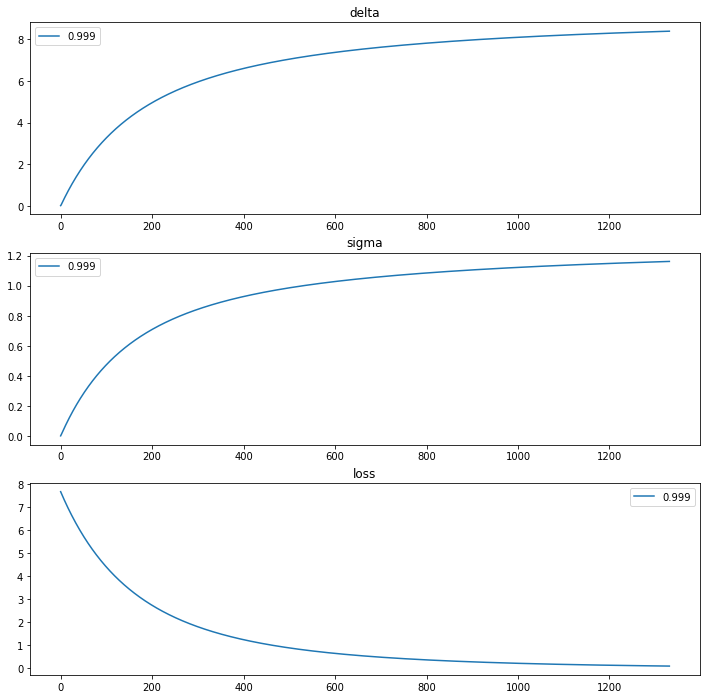

In [9]:
matrix = np.array([[1, 0.333, 2, 0.25, 1, 0.5, 2],
                  [3, 1, 0.142, 0.75, 3, 1.5, 6],
                  [0.5, 7, 1, 0.125, 0.5, 0.25, 1],
                  [4, 1.333, 8, 1, 4, 2, 8],
                  [1, 0.333, 2, 0.25, 1, 0.5, 2],
                  [2, 0.667, 4, 0.5, 2, 1, 4],
                  [0.5, 0.167, 1, 0.125, 0.5, 0.25, 1]])


D_u = iterative_improvement(matrix, [0.999], "WAMM")
define_outlier_element(D, 'Chi')

In [10]:
rankets

,rank Total,rank ServiceTime,rank employee_total_money
EmployeeId,,,
4,1.0,15.0,16.0
7,11.0,18.0,14.0
10,15.0,10.0,5.0
13,13.0,13.0,12.0
14,18.0,14.0,6.0
15,3.0,9.0,20.0
18,6.0,17.0,11.0
21,22.0,3.0,18.0
28,10.0,21.0,9.0


In [11]:
local_weights

array([0.17817773, 0.75140459, 0.07041769])

In [12]:
methods = ('distributive', 'ideal_point', 'geom', 'min')
Employee_ranked = pd.concat([pd.Series(get_Employee_weights(rankets, local_weights, method).head(45).index) \
           for method in methods], axis=1)
Employee_ranked.columns = methods

Employee_ranked[['ideal_point']]

            rank Total  rank ServiceTime  rank employee_total_money
EmployeeId                                                         
4             0.885609          0.059041                   0.055351
7             0.417219          0.254967                   0.327815
10            0.181818          0.272727                   0.545455
13            0.324324          0.324324                   0.351351
14            0.189189          0.243243                   0.567568
15            0.674157          0.224719                   0.101124
18            0.526761          0.185915                   0.287324
21            0.104651          0.767442                   0.127907
28            0.386503          0.184049                   0.429448
29            0.278481          0.481013                   0.240506
30            0.069388          0.832653                   0.097959
70            0.472393          0.257669                   0.269939
98            0.043783          0.919440        

,ideal_point
0,13
1,187
2,7
3,28
4,161
5,70
6,144
7,29
8,206
9,209


In [13]:
test = (
    Employee_stats_ranked.reset_index()
    .groupby("EmployeeId")
    .apply(
        lambda x: x[
            (list(Employee_criterions))
            + ["rank Total", "rank employee_total_money", "rank ServiceTime"]
        ].sort_values("employee_total_money", ascending=False)
    )
)

pd.merge(
    test.reset_index(),
    Employee_ranked[["geom"]].reset_index(),
    left_on="EmployeeId",
    right_on="geom",
).sort_values("index", ascending=True)


,EmployeeId,level_1,Total,ServiceTime,employee_total_money,rank Total,rank employee_total_money,rank ServiceTime,index,geom
10,21,6,2.800,79.0,505.00,22.0,18.0,3.0,0,21
31,207,33,5.950,310.0,314.58,14.0,23.0,6.0,1,207
14,30,9,2.575,77.0,589.84,24.0,17.0,2.0,2,30
16,98,10,2.950,51.0,38.50,21.0,25.0,1.0,3,98
30,206,32,5.150,412.0,1208.30,16.0,15.0,8.0,4,206
13,29,27,4.500,428.5,332.97,19.0,22.0,11.0,5,29
18,144,30,5.000,381.0,2458.54,17.0,10.0,7.0,6,144
24,187,31,4.300,491.0,465.98,20.0,19.0,16.0,7,187
4,13,25,6.975,446.0,1858.13,13.0,12.0,13.0,8,13
15,70,28,7.100,664.5,388.21,12.0,21.0,22.0,9,70


In [14]:
test = (
    Employee_stats_ranked.reset_index()
    .groupby("EmployeeId")
    .head(5)
    .sort_values("employee_total_money", ascending=False)
)
test[test.ShopId == 5]

,ShopId,EmployeeId,Total,employee_total_money,Total_money,ServiceTime,rank Total,rank ServiceTime,rank employee_total_money
24,5,10,5.600,3643.76,31872.42,416.0,15.0,10.0,5.0
26,5,14,4.900,3609.42,31872.42,456.0,18.0,14.0,6.0
22,5,209,5.300,3432.21,31872.42,476.0,5.0,23.0,7.0
12,5,161,4.800,3202.64,31872.42,413.0,7.0,19.0,8.0
15,5,176,4.800,2785.21,31872.42,347.5,9.0,12.0,3.0
30,5,144,5.000,2458.54,31872.42,381.0,17.0,7.0,10.0
5,5,18,5.350,2202.83,31872.42,430.0,6.0,17.0,11.0
25,5,13,6.975,1858.13,31872.42,446.0,13.0,13.0,12.0
17,5,192,5.800,1687.75,31872.42,483.0,2.0,20.0,13.0
23,5,7,7.350,1466.45,31872.42,507.0,11.0,18.0,14.0


In [15]:
Employee_stats_ranked

Total  employee_total_money  Total_money  ServiceTime  \
ShopId EmployeeId                                                            
4      4           444.000                444.00     21785.55         26.0   
5      4             5.050                481.36     31872.42        434.5   
4      15            2.550                 28.75     21785.55         56.0   
5      15            6.250                391.11     31872.42        357.0   
4      18            2.675                114.05     21785.55         62.0   
5      18            5.350               2202.83     31872.42        430.0   
4      21            2.800                505.00     21785.55         79.0   
       28            2.600               2118.19     21785.55        113.0   
5      28            4.825                772.46     31872.42        517.0   
4      30            2.575                589.84     21785.55         77.0   
       98            2.950                 38.50     21785.55         51.0   
       161           3.200                 25.00     21785.55        135.0   
5      161           4.800               3202.64     31872.42        413.0   
4      173           2.750               5569.18     21785.55        102.0   
       176           2.750               2287.68     21785.55         98.0   
5      176           4.800               2785.21     31872.42        347.5   
4      192           4.300                 22.45     21785.55         69.0   
5      192           5.800               1687.75     31872.42        483.0   
4      196           2.900               2870.65     21785.55         85.0   
5      196           5.000               1107.91     31872.42        407.0   
4      205           2.750               7105.46     21785.55         96.0   
       209           2.825                 66.80     21785.55        206.5   
5      209           5.300               3432.21     31872.42        476.0   
       7             7.350               1466.45     31872.42        507.0   
       10            5.600               3643.76     31872.42        416.0   
       13            6.975               1858.13     31872.42        446.0   
       14            4.900               3609.42     31872.42        456.0   
       29            4.500                332.97     31872.42        428.5   
       70            7.100                388.21     31872.42        664.5   
       100           8.750                 62.60     31872.42        701.5   
       144           5.000               2458.54     31872.42        381.0   
       187           4.300                465.98     31872.42        491.0   
       206           5.150               1208.30     31872.42        412.0   
       207           5.950                314.58     31872.42        310.0   

                   rank Total  rank ServiceTime  rank employee_total_money  
ShopId EmployeeId                                                           
4      4                  1.0              15.0                       16.0  
5      4                  1.0              15.0                       16.0  
4      15                 3.0               9.0                       20.0  
5      15                 3.0               9.0                       20.0  
4      18                 6.0              17.0                       11.0  
5      18                 6.0              17.0                       11.0  
4      21                22.0               3.0                       18.0  
       28                10.0              21.0                        9.0  
5      28                10.0              21.0                        9.0  
4      30                24.0               2.0                       17.0  
       98                21.0               1.0                       25.0  
       161                7.0              19.0                        8.0  
5      161                7.0              19.0                        8.0  
4      173               23.0               5.0          